In [308]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units

from BASE9Analysis import readGaiaData
from BASE9Analysis import findSeparation
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import font_manager
#point to font directory and find files within it
font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
#add fonts
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
# set font
plt.rcParams['font.family'] = 'Noto Sans JP'

%matplotlib inline

In [283]:
# %load_ext autoreload
# %autoreload 2
# from getGaiaData import GaiaClusterMembers

In [284]:
# cluster = GaiaClusterMembers(295.3250, 40.19, 1)
# cluster.verbose = 1
# cluster.getData()

In [285]:
# cluster.saveDataToFile('clusterGaiaData.ecsv')

In [309]:
#read data from ecsv and round to 4 decimals
originalGaia=readGaiaData('M67data.ecsv')
originalGaia=originalGaia.round(4)

In [310]:
#define filepaths for samplemasses, memberships, and photometry
sm = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.massSamples"
mem = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.membership"
ph = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.phot"

In [311]:
#create dataframe for photometry, and define analysis columns
phot = pd.read_csv(ph, sep='\s+')
phot['m1Mean'] = -1
phot['m1Std'] = -2
phot['m2Mean'] = -3
phot['m2Std'] = -4
phot['qMean'] = -5
phot['qStd'] = -6
phot['memMean'] = -7
phot['memStd'] = -8
phot['member'] = False
phot['binary'] = False
phot

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,J_2M,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
0,10010400015,9.9643,11.6368,8.7188,12.0640,11.9650,10.1610,9.0880,8.5260,6.758,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1,10618000016,10.0908,11.4559,8.9425,13.2814,10.9032,9.0598,8.5864,8.8477,7.240,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
2,10719500017,10.1428,11.4292,9.0287,99.9000,99.9000,99.9000,99.9000,99.9000,7.356,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
3,11321600029,10.9064,11.7692,10.0000,99.9000,99.9000,99.9000,99.9000,99.9000,8.723,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
4,10007800034,11.0790,11.9665,10.1455,99.9000,99.9000,99.9000,99.9000,99.9000,8.819,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,10639026771,20.4824,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.900,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1906,10095627116,20.5168,99.9000,99.9000,21.0998,99.9000,20.2313,99.9000,99.9000,99.900,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1907,10130227255,20.5313,99.9000,99.9000,99.9000,20.5410,20.3388,99.9000,99.9000,99.900,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1908,10572927462,20.5560,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,16.851,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False


In [312]:
# get the IDs for the samplemasses
massIDs = np.loadtxt(sm,max_rows = 1, dtype=str)
massIDs = np.char.replace(massIDs,'mass','')
massIDs = np.char.replace(massIDs,'ratio','')
massIDs = np.char.replace(massIDs,'"','')
massIDs = (massIDs[massIDs != '']) 
massIDs

array(['10010400015', '10010400015', '10618000016', ..., '10130227255',
       '10572927462', '10572927462'], dtype='<U11')

In [313]:
# get the masses
masses = np.loadtxt(sm,skiprows=1)
print(masses.shape)
print(masses.shape[1]/2.)
#print(type(masses))

(9341, 3818)
1909.0


In [314]:
# get the memberships 
membership = np.loadtxt(mem)
print(membership.shape)

(9341, 1909)


In [315]:
#calculate the binary fraction
from scipy import stats
nBinary = 0
nCluster = 0
count = 0
# m1ArrTot = []
for i in range(0,masses.shape[1],2):
    # get the row in the phot file
    iden = int(massIDs[i])
    row = phot.loc[(phot['id'] == iden)]
    #print(row['id'])
    
    # get the column in the membership file
    
    imem = int((i/2))
    memArr = membership[:,imem]
    memMean = np.mean(memArr)
    memStd = np.std(memArr)
    
     #add to the phot df
    phot.at[row.index[0], 'memMean'] = memMean
    phot.at[row.index[0], 'memStd'] = memStd
    
    if (memMean - 3*memStd > 0):
        phot.at[row.index[0], 'member'] = True

        nCluster += 1
        
        # get the masses
        m1Arr = masses[:,i]
        #print(m1Arr)
        # m1ArrTot.append(m1Arr)
        qArr = masses[:,(i + 1)]
        m2Arr = m1Arr*qArr
        m2Mean = np.mean(m2Arr)
        m1Mean = np.mean(m1Arr)
        m2Std = np.std(m2Arr)
        qMean = np.mean(qArr)
        qStd = np.std(qArr)

        # add to the phot df masses (to do)
        phot.at[row.index[0], 'qMean'] = qMean
        phot.at[row.index[0], 'qStd'] = qStd
        phot.at[row.index[0], 'm1Mean'] = m1Mean
        phot.at[row.index[0], 'm2Mean'] = m2Mean
    #print(stats.percentileofscore(m2Arr, 0))
        #if (stats.percentileofscore(m2Arr, 0) > 0.2): #3sigma below median (49.8%)
        if (m2Mean - 3*m2Std > 0): #if there is a greater than 3sig difference from mean, include as binary
            nBinary += 1
            phot.at[row.index[0], 'binary'] = True
            
        if (qMean>=0.5): #exclude mass ratios < .5 
            count += 1
            
    #print(m1Arr)   
print(f"# Binaries: {nBinary}")
print(f"# Cluster objects: {nCluster}")
print(f"Binary Fraction: {nBinary/nCluster:.4f}")
print(f"Std: {np.sqrt(nBinary)/nCluster:.3f}")
print(f"q>=0.5 Binaries: {count}")
print(f"q>=0.5 binary fraction: {count/nCluster:.4f}")
print(f"q>=0.5 std: {np.sqrt(count)/nCluster:.3f}")

# Binaries: 471
# Cluster objects: 1726
Binary Fraction: 0.2729
Std: 0.013
q>=0.5 Binaries: 409
q>=0.5 binary fraction: 0.2370
q>=0.5 std: 0.012


In [316]:
# Load the data from file
res_data = np.loadtxt('/Users/Claire/Documents/Code/current/ANNACRNN/NGC_6819.res', skiprows=1, usecols=[0, 1, 2, 3, 5])
age_all, metallicity_all, distance_mod_all, reddening_all, stage = res_data.T

# Only use data from stage 3, and discard burn-in data
index = np.where(stage == 3)
distance_mod, reddening = distance_mod_all[index], reddening_all[index]

# Calculate statistics for distance modulus and reddening
distance_mod_mean, distance_mod_std = np.average(distance_mod), np.std(distance_mod)
reddening_mean, reddening_std = np.average(reddening), np.std(reddening)

# Format the output strings
distance_mod_string = f"{distance_mod_mean:.3f} \u00B1 {distance_mod_std:.4f}"
reddening_string = f"{reddening_mean:.4f} \u00B1 {reddening_std:.4f}"

# Print the results
print(f"Distance Modulus: {distance_mod_string}")
print(f"Reddening: {reddening_string} (mmag)")


Distance Modulus: 12.371 ± 0.0029
Reddening: 0.4957 ± 0.0031 (mmag)


In [318]:
# Calculate half-mass radius
# 50% of stars are within 0.4 degrees of cluster center from first hist
import math

distance = 10 ** ((distance_mod_mean + 5 - reddening_mean) / 5)

r_deg = 0.1  # better way to grab this value directly from hist?
r = r_deg * 3600
R_half_pc = r * distance / 206265  # seems bigger than literature values, but maybe because we are going out further?
R_half_m = R_half_pc * 3.086 * 10 ** 16

R_core = 4.96 * 3600 #not sure what the core radius is that was used
a = R_core * np.sqrt(2)
# 1.305*R

# Calculate half-mass relaxation time
# phothalfmass = merged_Frame_all.loc[(merged_Frame_all['distance'] < 0.4) ]

#define a dataframe including photometric members
photMems = phot.loc[phot['member']]
# calculate m2Mean from m1Mean and q
phot.loc[phot['member'], 'm2Mean'] = phot.loc[phot['member'], 'm1Mean'] * phot.loc[phot['member'], 'qMean']

# find the sums of mass 1 and mass 2, and add them together for total mass
mass1 = sum(photMems['m1Mean'])
mass2 = sum(photMems['m2Mean'])
mass_tot = (mass1 + mass2)

# convert total mass in solar masses to kilograms
M = (mass1 + mass2) * 1.9891 * 10 ** 30
# gravitational constant
G = 6.67 * 10 ** -11 
# number of members
N = len(photMems)
const = 0.1

# Binney & Tremaine half mass relaxation time equation
t_rh = (((0.17 * N) / np.log(const * N)) * (math.sqrt(((R_half_m) ** 3) / (G * M)))) / 31536000

# Spitzer & Hart half mass relaxation time equation
m = np.mean(photMems['m1Mean']) * 1.9891 * 10 ** 30
t_rh_spitzer = (0.06 * (M ** 0.5) * (R_half_m ** 1.5)) / (m * (G ** 0.5) * np.log10(0.4 * N)) / 31536000

#Heggie & Hut - Plummer Model half mass relaxation time equation, not sure what lambda is
t_rh_heggie = ( (0.206 * N * (a**1.5)) / (np.sqrt(G*M) * np.log(10)) ) / 31536000 #from table
t_rh_heggie2 = ( (0.138 * (N**0.5) * (R_half_m**1.5)) / (np.sqrt(G*m) * np.log(10)) ) / 31536000 #from pg 147

# Calculate the mass segregation time for the most massive star
# Calculate max m and avg m
avg_m = (mass_tot / N)* 1.9891 * 10 ** 30
m_max = max(photMems['m1Mean']) * 1.9891 * 10 ** 30
t_seg = (avg_m / m_max) * t_rh
cluster_age = 10**np.mean(age_all)

# print results with labels and units
print(f"Half-mass radius: {R_half_pc:.2f} pc")
print(f'Total mass: {mass_tot:.2e} M☉\n')
print(f"Half-mass relaxation time (Binney & Tremaine): {t_rh:.2e} years")
print(f"Half-mass relaxation time (Spitzer & Hart): {t_rh_spitzer:.2e} years")
print(f"Half-mass relaxation time (Heggie & Hut - Plummer): {t_rh_heggie2:.2e} years")
print(f"Mass segregation time for the most massive star: {t_seg:.2e} years\n")
print(f'Dynamical Relaxations (Binney & Tremaine): {cluster_age/t_rh}')
print(f'Dynamical Relaxations (Spitzer & Hart): {cluster_age/t_rh_spitzer}')
print(f'Dynamical Relaxations (Heggie & Hut - Plummer): {cluster_age/t_rh_heggie2}')

Half-mass radius: 4.14 pc
Total mass: 2.49e+03 M☉

Half-mass relaxation time (Binney & Tremaine): 1.44e+08 years
Half-mass relaxation time (Spitzer & Hart): 1.22e+08 years
Half-mass relaxation time (Heggie & Hut - Plummer): 3.00e+08 years
Mass segregation time for the most massive star: 1.27e+08 years

Dynamical Relaxations (Binney & Tremaine): 17.417417369845207
Dynamical Relaxations (Spitzer & Hart): 20.458488726050643
Dynamical Relaxations (Heggie & Hut - Plummer): 8.31821500205846


In [319]:
#Calculate t_seg for each star with Binney & Tremaine model, and store it in phot dataframe for later
avg_m = (mass_tot / N) * 1.9891 * 10 ** 30
m_star = photMems['m1Mean'] * 1.9891 * 10 ** 30
phot['t_seg'] = (avg_m / m_star) * t_rh

In [296]:
# plt.hist(m1ArrTot)
# plt.xlim(0,10)

In [320]:
#include only cluster members and single stars
singlePhot = phot.loc[(phot['member']) & (phot['binary']== False)]
singlePhot['binary'].unique() #check all binary columns are false
# singlePhot

array([False])

In [321]:
#include only binary stars
binaryPhot = phot.loc[phot['binary']]
binaryPhot['binary'].unique() #check all binary columns are true
#photBinary

array([ True])

In [322]:
#select photometry between magnitudes for single and binary stars
topmag=15
bottommag=18.5
cutSinglePhot = singlePhot.loc[(singlePhot['G']  > topmag) & (singlePhot['G']  < bottommag)]
cutBinaryPhot = binaryPhot.loc[(binaryPhot['G']  > topmag) & (binaryPhot['G']  < bottommag)]
# cutSinglePhot
# cutBinaryPhot

In [323]:
binaryPhot

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,J_2M,...,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary,t_seg
18,10079200118,12.5085,13.0806,11.7925,99.9000,99.9000,99.9000,99.9000,99.9000,10.843,...,-2,1.543245,-4,0.972027,0.052500,0.995932,6.365169e-02,True,True,130426929.183116
19,10014000119,12.5173,13.1115,11.7863,13.3066,12.6870,12.2810,12.0270,11.9090,10.790,...,-2,1.452542,-4,0.910220,0.182120,0.944925,2.280457e-01,True,True,129760119.817638
20,10291800122,12.5621,13.1809,11.8130,13.3745,12.7150,12.3100,12.0640,11.9320,10.804,...,-2,1.277381,-4,0.799065,0.166017,0.999998,3.616864e-05,True,True,129534477.25124
21,10320700125,12.5894,13.1961,11.8481,13.3969,12.7100,12.3140,12.0760,11.9540,10.844,...,-2,1.402037,-4,0.879090,0.047201,0.998533,3.405517e-02,True,True,129836684.378075
22,10276600132,12.6390,13.2478,11.8866,13.3457,13.0830,12.5690,12.2340,12.0017,10.867,...,-2,1.316488,-4,0.824260,0.047268,0.999882,2.579837e-03,True,True,129649584.689891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,10588715865,19.2640,19.9550,18.4009,20.2450,19.1709,18.7523,99.9000,18.1414,99.900,...,-2,0.343552,-4,0.487273,0.092093,1.000000,0.000000e+00,True,True,293700285.460317
1879,11196416068,19.2877,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,16.319,...,-2,0.624432,-4,0.973296,0.023495,0.998745,1.297811e-02,True,True,322762682.204102
1880,10006017074,19.4167,99.9000,99.9000,99.9000,99.9000,18.6213,99.9000,99.9000,99.900,...,-2,0.619803,-4,0.974574,0.021689,1.000000,0.000000e+00,True,True,325600460.314625
1883,11717518632,19.6066,99.9000,99.9000,99.9000,19.6921,18.1839,18.7557,18.6017,99.900,...,-2,0.450144,-4,0.686959,0.124208,1.000000,5.665158e-08,True,True,316011900.789499


In [324]:
print(binaryPhot[binaryPhot['m1Mean'] == -1]['m1Mean'])

Series([], Name: m1Mean, dtype: float64)


Index(['source_id', 'G', 'G_BP', 'G_RP', 'ra', 'dec'], dtype='object')

In [325]:
binaryGaiaData = pd.merge(originalGaia, binaryPhot, on=['G','G_BP'])
singleGaiaData = pd.merge(originalGaia, singlePhot, on=['G','G_BP'])
cutBinaryGaiaData = pd.merge(originalGaia, cutBinaryPhot, on=['G','G_BP'])
cutSingleGaiaData = pd.merge(originalGaia, cutSinglePhot, on=['G','G_BP'])

# cutBinaryGaiaData

In [326]:
singleGaiaData['distance'] = findSeparation(singleGaiaData)
binaryGaiaData['distance'] = findSeparation(binaryGaiaData)
cutSingleGaiaData['distance'] = findSeparation(cutSingleGaiaData)
cutBinaryGaiaData['distance'] = findSeparation(cutBinaryGaiaData)

2143.2934816167217 1071.6467408083608 0.08148438730022378


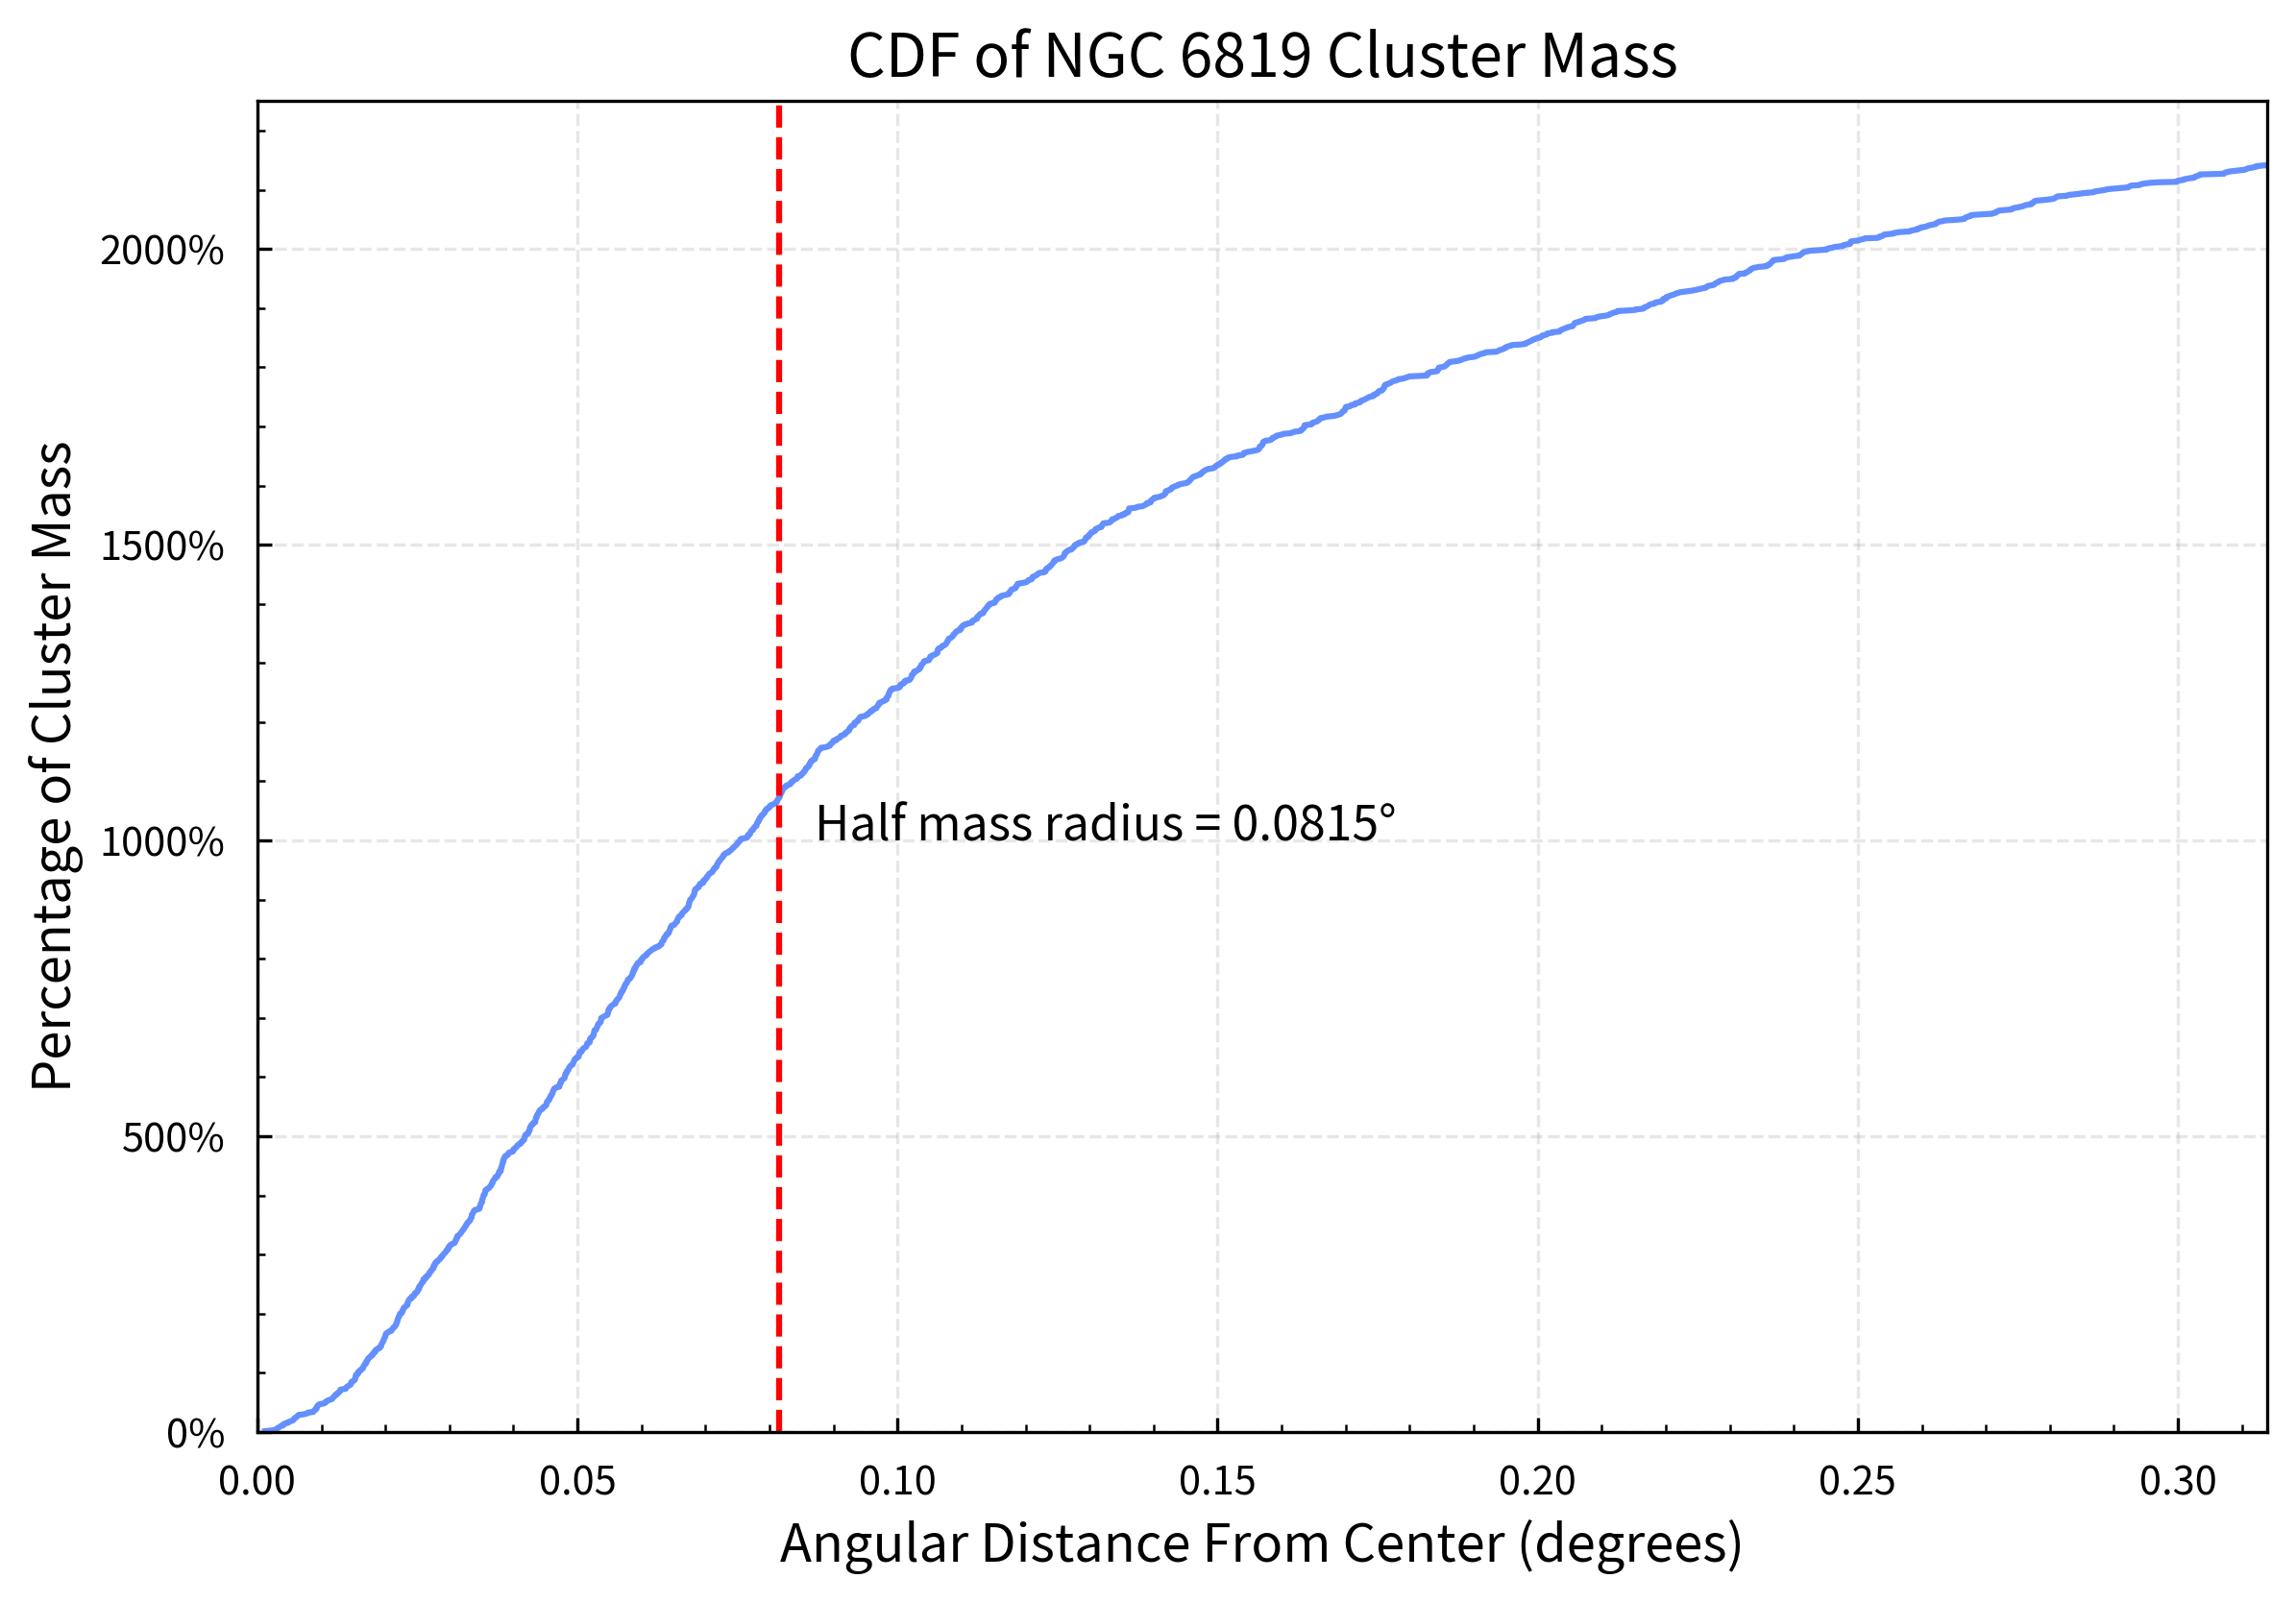

In [327]:
# Create separate total mass columns for binary and single stars
binaryGaiaData['total_mass'] = binaryGaiaData['m1Mean'] + binaryGaiaData['m2Mean']
singleGaiaData['total_mass'] = singleGaiaData['m1Mean']

# Concatenate the dataframes
concatenatedGaiaData = pd.concat([binaryGaiaData, singleGaiaData])
#Sort the dataframe by distance
concatenatedGaiaData = concatenatedGaiaData.sort_values(by='distance')

# Compute the cumulative sum of the total_mass column
concatenatedGaiaData['cumulative_mass'] = concatenatedGaiaData['total_mass'].cumsum()

# Compute the total mass
total_mass = concatenatedGaiaData['total_mass'].sum()

# Find the radius at which half of the total mass is reached
half_mass_radius = concatenatedGaiaData.loc[concatenatedGaiaData['cumulative_mass'] >= total_mass/2, 'distance'].iloc[0]


# Plot the cumulative mass as a function of radius
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.plot(concatenatedGaiaData['distance'], concatenatedGaiaData['cumulative_mass'], color='#648fff')
plt.axvline(x=half_mass_radius, color='red', linestyle='--')
plt.annotate(text=f'Half mass radius = {half_mass_radius:.4f}\u00b0', color='black', xy=(.087,1000), xytext=(.087,1000), size=12)
plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Cluster Mass", fontsize=13)
plt.title("CDF of NGC 6819 Cluster Mass", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter())
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.314)
ax.set_ylim(0,None)
print(total_mass, total_mass/2, half_mass_radius)
plt.show()


2143.2934816167217 1071.6467408083608 0.08148438730022378


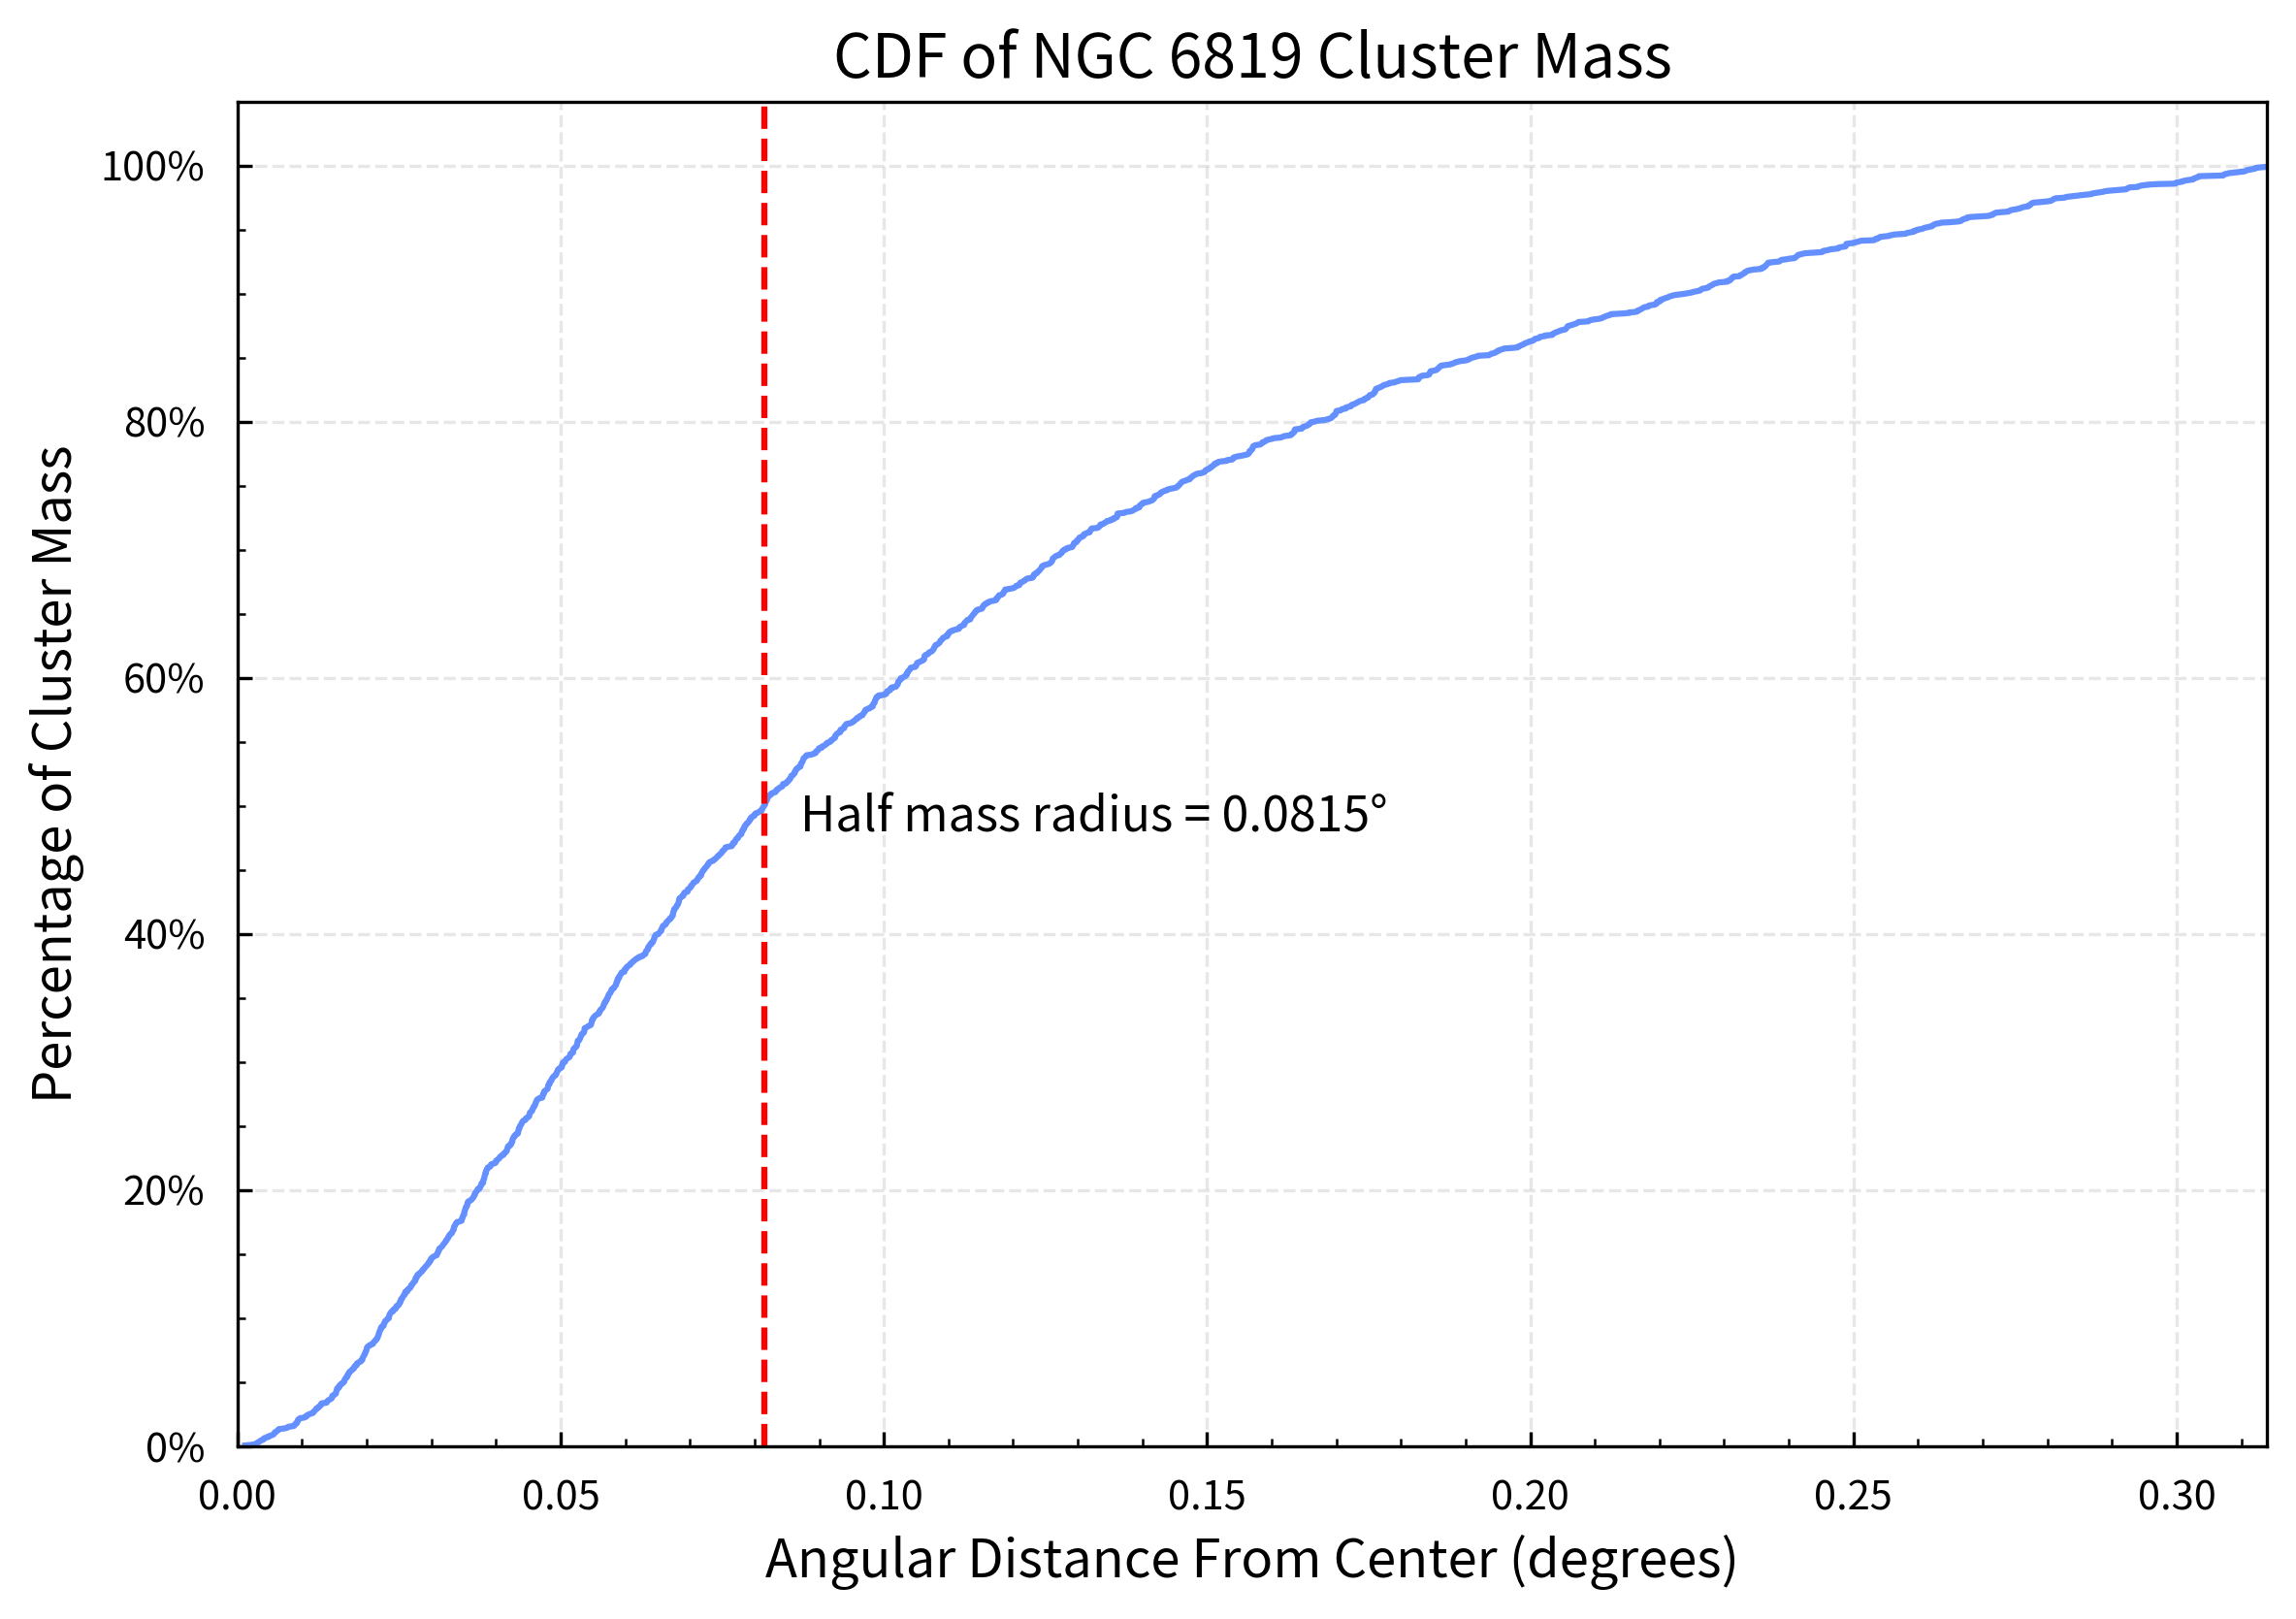

In [328]:
# Create separate total mass columns for binary and single stars
binaryGaiaData['total_mass'] = binaryGaiaData['m1Mean'] + binaryGaiaData['m2Mean']
singleGaiaData['total_mass'] = singleGaiaData['m1Mean']

# Concatenate the dataframes
concatenatedGaiaData = pd.concat([binaryGaiaData, singleGaiaData])

#Sort the dataframe by distance
concatenatedGaiaData = concatenatedGaiaData.sort_values(by='distance')

# Compute the cumulative sum of the total_mass column
concatenatedGaiaData['cumulative_mass'] = concatenatedGaiaData['total_mass'].cumsum()

# Compute the total mass
total_mass = concatenatedGaiaData['total_mass'].sum()

# Compute the cumulative percentage of the total mass
concatenatedGaiaData['cumulative_percentage'] = concatenatedGaiaData['cumulative_mass'] / total_mass * 100

# Find the radius at which half of the total mass is reached
half_mass_radius = concatenatedGaiaData.loc[concatenatedGaiaData['cumulative_percentage'] >= 50, 'distance'].iloc[0]

# Plot the cumulative percentage as a function of radius
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.plot(concatenatedGaiaData['distance'], concatenatedGaiaData['cumulative_percentage'], color='#648fff')
plt.axvline(x=half_mass_radius, color='red', linestyle='--')
plt.annotate(text=f'Half mass radius = {half_mass_radius:.4f}\u00b0', color='black', xy=(.087,48), xytext=(.087,48), size=12)
plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Cluster Mass", fontsize=13)
plt.title("CDF of NGC 6819 Cluster Mass", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.314)
ax.set_ylim(0,None)
print(total_mass, total_mass/2, half_mass_radius)
plt.show()


In [ ]:
# Calculate half-mass radius
# 50% of stars are within 0.4 degrees of cluster center from first hist
import math

distance = 10 ** ((distance_mod_mean + 5 - reddening_mean) / 5)

r_deg = half_mass_radius  # better way to grab this value directly from hist?
r = r_deg * 3600
R_half_pc = r * distance / 206265  # seems bigger than literature values, but maybe because we are going out further?
R_half_m = R_half_pc * 3.086 * 10 ** 16

R_core = 4.96 * 3600 #not sure what the core radius is that was used
a = R_core * np.sqrt(2)
# 1.305*R

# Calculate half-mass relaxation time
# phothalfmass = merged_Frame_all.loc[(merged_Frame_all['distance'] < 0.4) ]

#define a dataframe including photometric members
photMems = phot.loc[phot['member']]
# calculate m2Mean from m1Mean and q
phot.loc[phot['member'], 'm2Mean'] = phot.loc[phot['member'], 'm1Mean'] * phot.loc[phot['member'], 'qMean']

# find the sums of mass 1 and mass 2, and add them together for total mass
mass1 = sum(photMems['m1Mean'])
mass2 = sum(photMems['m2Mean'])
mass_tot = (mass1 + mass2)

# convert total mass in solar masses to kilograms
M = (mass1 + mass2) * 1.9891 * 10 ** 30
# gravitational constant
G = 6.67 * 10 ** -11 
# number of members
N = len(photMems)
const = 0.1

# Binney & Tremaine half mass relaxation time equation
t_rh = (((0.17 * N) / np.log(const * N)) * (math.sqrt(((R_half_m) ** 3) / (G * M)))) / 31536000

# Spitzer & Hart half mass relaxation time equation
m = np.mean(photMems['m1Mean']) * 1.9891 * 10 ** 30
t_rh_spitzer = (0.06 * (M ** 0.5) * (R_half_m ** 1.5)) / (m * (G ** 0.5) * np.log10(0.4 * N)) / 31536000

#Heggie & Hut - Plummer Model half mass relaxation time equation, not sure what lambda is
t_rh_heggie = ( (0.206 * N * (a**1.5)) / (np.sqrt(G*M) * np.log(10)) ) / 31536000 #from table
t_rh_heggie2 = ( (0.138 * (N**0.5) * (R_half_m**1.5)) / (np.sqrt(G*m) * np.log(10)) ) / 31536000 #from pg 147

# Calculate the mass segregation time for the most massive star
# Calculate max m and avg m
avg_m = (mass_tot / N)* 1.9891 * 10 ** 30
m_max = max(photMems['m1Mean']) * 1.9891 * 10 ** 30
t_seg = (avg_m / m_max) * t_rh
cluster_age = 10**np.mean(age_all)

# print results with labels and units
print(f"Half-mass radius: {R_half_pc:.2f} pc")
print(f'Total mass: {mass_tot:.2e} M☉\n')
print(f"Half-mass relaxation time (Binney & Tremaine): {t_rh:.2e} years")
print(f"Half-mass relaxation time (Spitzer & Hart): {t_rh_spitzer:.2e} years")
print(f"Half-mass relaxation time (Heggie & Hut - Plummer): {t_rh_heggie2:.2e} years")
print(f"Mass segregation time for the most massive star: {t_seg:.2e} years\n")
print(f'Dynamical Relaxations (Binney & Tremaine): {cluster_age/t_rh}')
print(f'Dynamical Relaxations (Spitzer & Hart): {cluster_age/t_rh_spitzer}')
print(f'Dynamical Relaxations (Heggie & Hut - Plummer): {cluster_age/t_rh_heggie2}')

Half-mass radius: 3.37 pc
Total mass: 2.49e+03 M☉

Half-mass relaxation time (Binney & Tremaine): 1.06e+08 years
Half-mass relaxation time (Spitzer & Hart): 8.99e+07 years
Half-mass relaxation time (Heggie & Hut - Plummer): 2.21e+08 years
Mass segregation time for the most massive star: 9.33e+07 years

Dynamical Relaxations (Binney & Tremaine): 23.679479525202478
Dynamical Relaxations (Spitzer & Hart): 27.81390344034727
Dynamical Relaxations (Heggie & Hut - Plummer): 11.308852377189485


In [ ]:
cutSingleGaiaData['distance'] = findSeparation(cutSingleGaiaData)
cutBinaryGaiaData['distance'] = findSeparation(cutBinaryGaiaData)
singleGaiaData['distance'] = findSeparation(singleGaiaData)
binaryGaiaData['distance'] = findSeparation(binaryGaiaData)
#copying and putting cell above to test

In [ ]:
# #massratio CDF
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

# single = qcutSingle['distance']
# binary = qcutBinary['distance']

# singleSample = single.shape[0]
# binarySample = binary.shape[0]

# singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b', label=f'Single stars (n={singleSample}) ')
# binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g', label= f'Binary stars (n={binarySample}) ')

# ks_result, twoside_pvalue = ks_2samp(single,binary)
# ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')

# plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
# plt.ylabel("Percentage of Stars", fontsize=13)
# plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
# plt.grid(linestyle='--', alpha=0.3)

# #plt.text(.008, .88, 'K-S "two-sided" P-value: 0.00032\nK-S "less" P-value: 0.970\nBinary sample: 347\nSingle sample: 35',fontsize = 10, 
# #          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# # custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
# #                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),
# #                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-')]

# twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
# less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
# ax.legend(loc=2, fontsize=8)
# #leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
# #plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

# #plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
# #plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
# from matplotlib.ticker import PercentFormatter
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# ax.yaxis.get_ticklocs(minor=True)
# ax.minorticks_on()
# ax.tick_params(which='both', direction="in")
# ax.tick_params(axis='both', pad=8)
# ax.set_xlim(0,.314)
# plt.show()

In [ ]:
binaryGaiaData['m1Mean']

0      0.844400
1      1.194867
2      0.686451
3      1.328925
4      0.948358
         ...   
448    0.868141
449    0.793533
450    1.016734
451    0.761930
452    0.728307
Name: m1Mean, Length: 453, dtype: float64

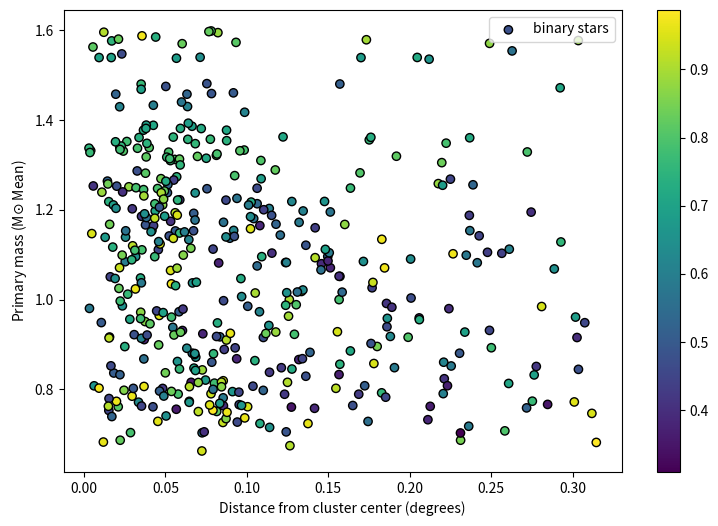

In [ ]:
f,ax = plt.subplots(figsize=(9,6))
r= binaryGaiaData['qMean']
#plt.scatter(singleGaiaData['distance'], singleGaiaData['m1Mean'], color='b', label="single stars")
plt.scatter(binaryGaiaData['distance'], binaryGaiaData['m1Mean'], c=r, cmap=plt.cm.get_cmap("viridis"), edgecolor='black', label='binary stars')
plt.colorbar()
plt.xlabel("Distance from cluster center (degrees)")
plt.ylabel("Primary mass (M$\odot$ Mean)")
plt.legend()

In [ ]:
avg_spacing = (np.max(binaryGaiaData['m1Mean']) - np.min(binaryGaiaData['m1Mean']))/3
print(avg_spacing)
print(np.min(binaryGaiaData['m1Mean'])+(2*avg_spacing))

0.312040911322842
1.2865540050672664


0.15008371906103052
0.0020227718816148927
1.0103166944227273e-05


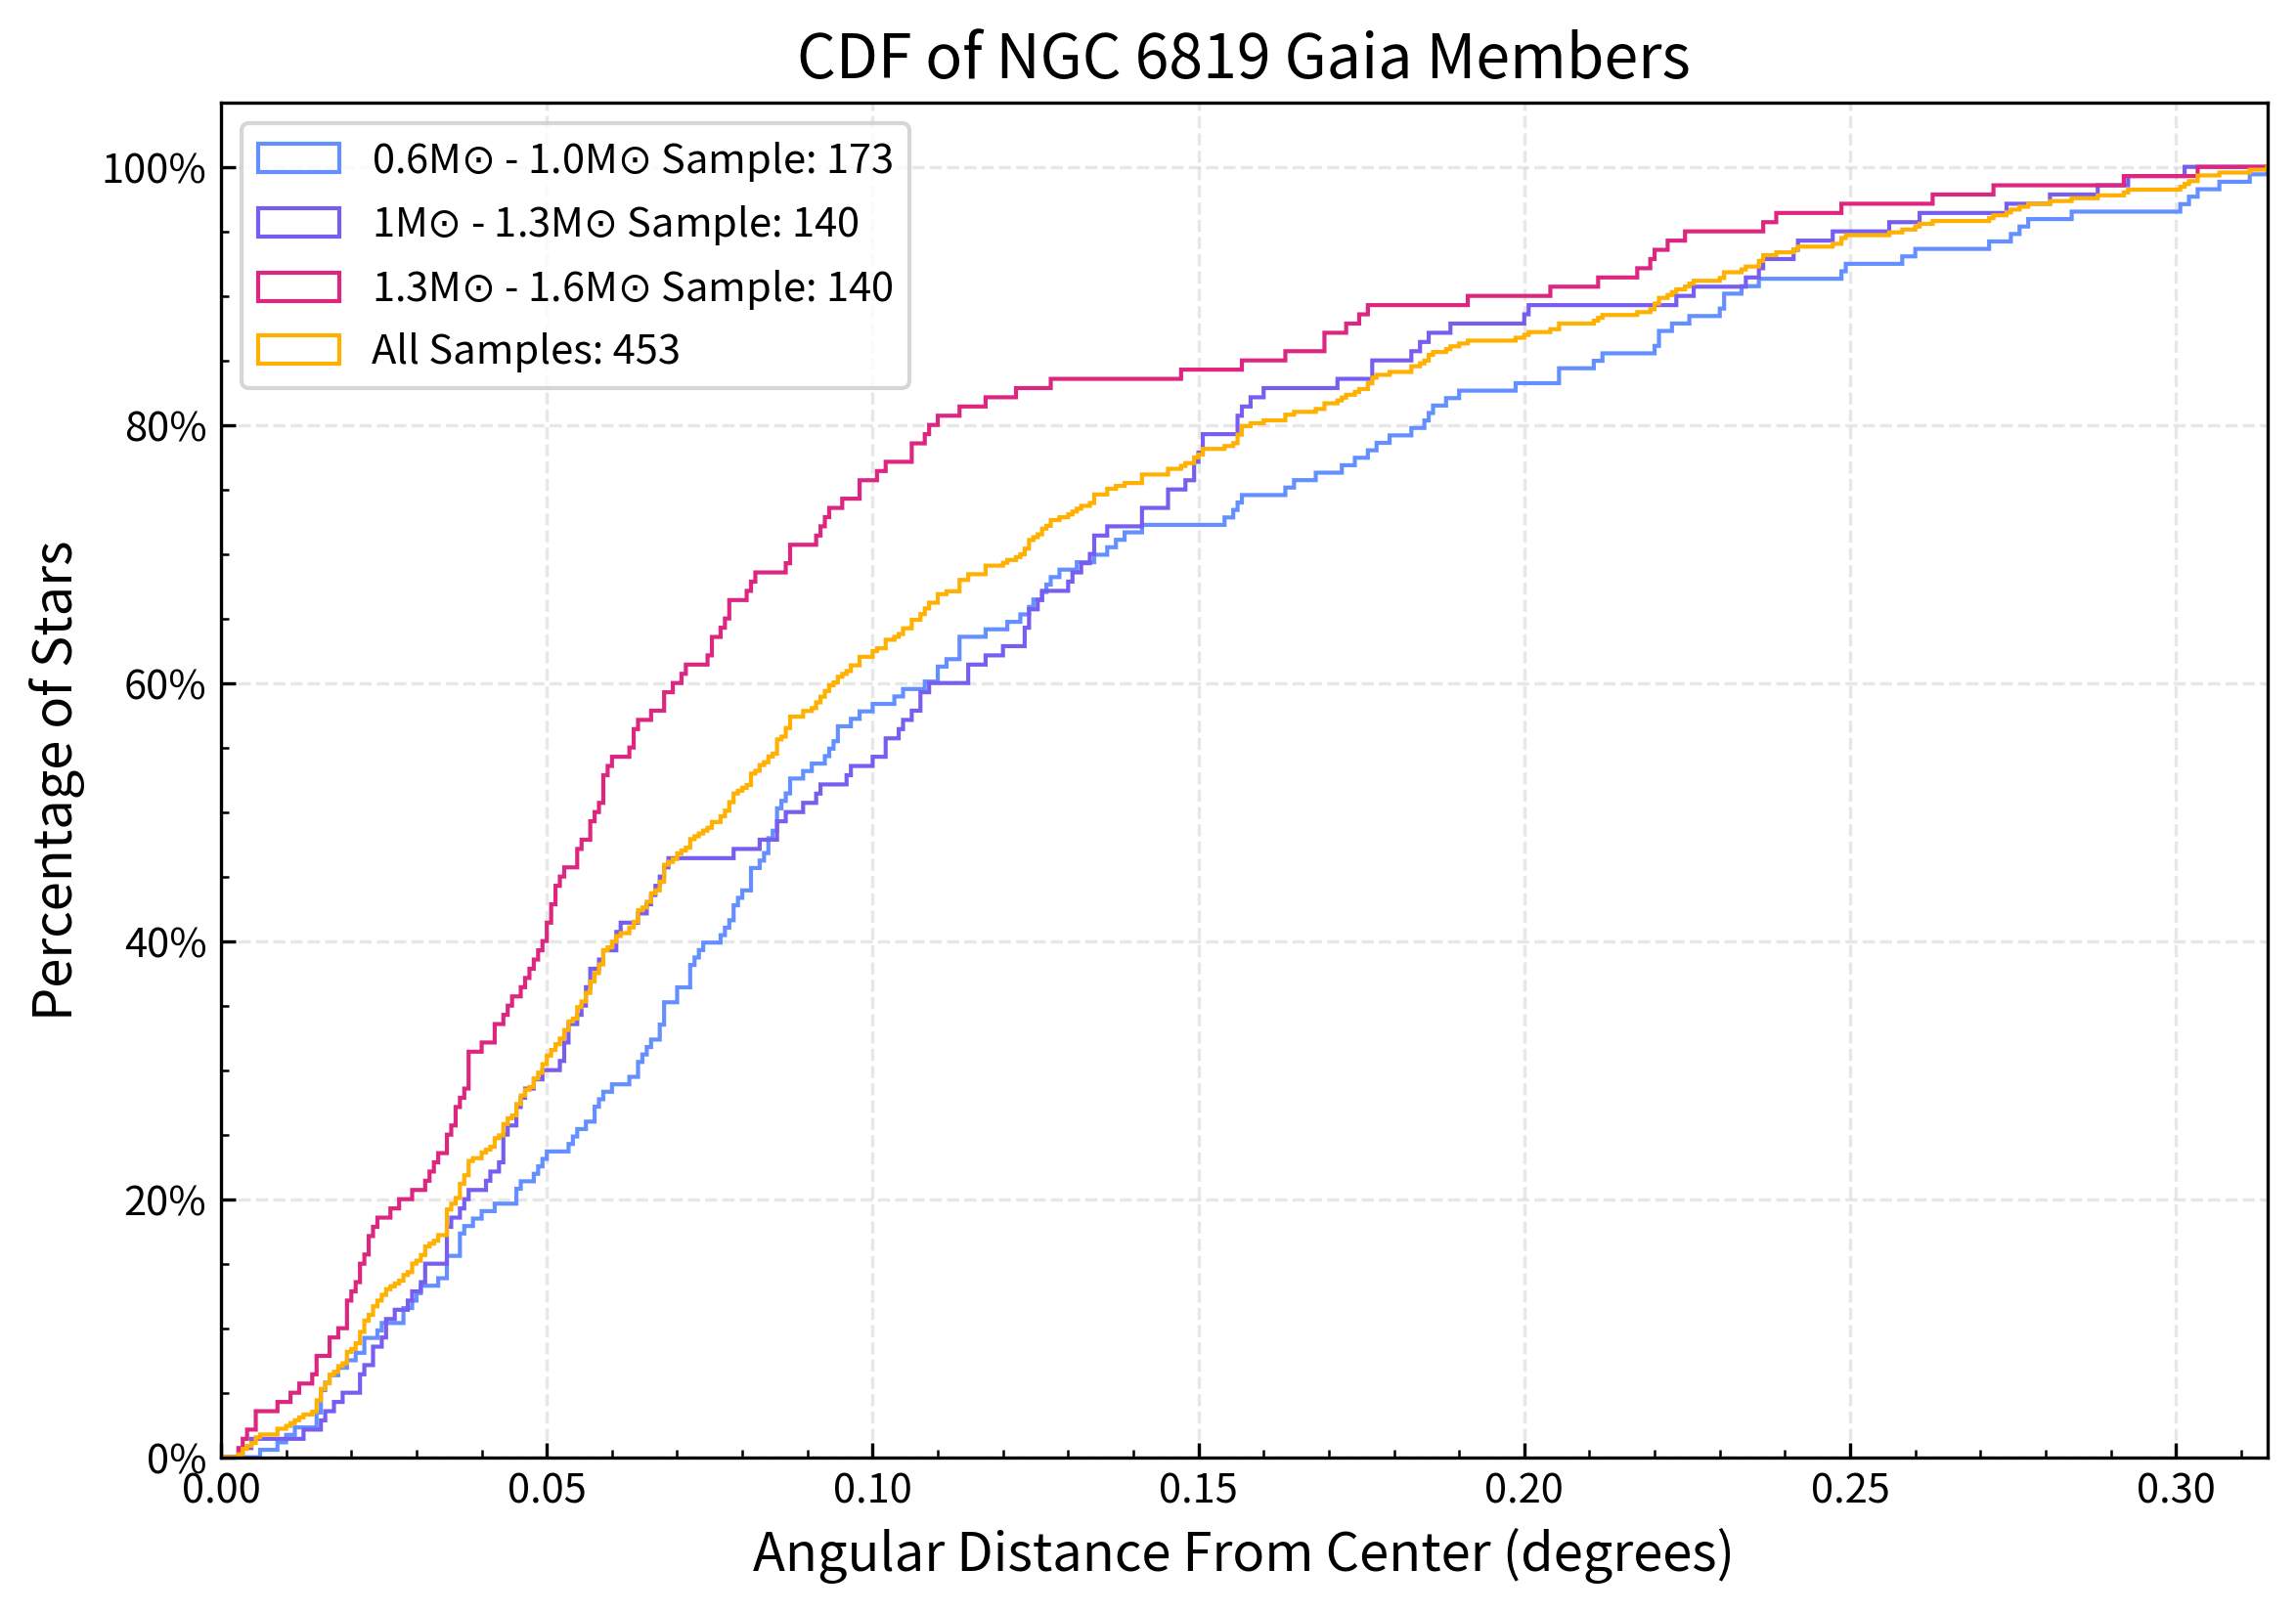

In [ ]:
#mass ranges CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

binaryfilter1 = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  >= np.min(binaryGaiaData['m1Mean'])) & (binaryGaiaData['m1Mean']  <= .96)]
binaryfilter2 = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > .96) & (binaryGaiaData['m1Mean']  <=  1.2)]
binaryfilter3 = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1.2 ) & (binaryGaiaData['m1Mean']  <=  np.max(binaryGaiaData['m1Mean']))]

#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

bin1 = binaryfilter1['distance']
bin2 = binaryfilter2['distance']
bin3 = binaryfilter3['distance']
allbinaries = binaryGaiaData['distance']

bin1Sample = bin1.shape[0]
bin2Sample = bin2.shape[0]
bin3Sample = bin3.shape[0]
allSample = binaryGaiaData.shape[0]
# print(binary)

ax.hist(bin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f'0.6M$\odot$ - 1.0M$\odot$ Sample: {bin1Sample}')
ax.hist(bin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#785ef0', label=f'1M$\odot$ - 1.3M$\odot$ Sample: {bin2Sample}')
ax.hist(bin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#dc267f', label=f'1.3M$\odot$ - 1.6M$\odot$ Sample: {bin3Sample}')
ax.hist(allbinaries, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#FFB000', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(bin1,bin2)
ks_result, less_pvalue1 = ks_2samp(bin1,bin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(bin2,bin3)
ks_result, less_pvalue2= ks_2samp(bin2,bin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(bin1,bin3)
ks_result, less_pvalue3 = ks_2samp(bin1,bin3,alternative='less')
print(twoside_pvalue3 )

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.legend(loc='upper left')
# plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\n1.0M$\odot$ - 1.3M$\odot$ Sample: {binarySample}\n0.6M$\odot$ - 1.0M$\odot$ Sample: {singleSample}',fontsize = 10, 
#          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
# plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
# plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

0.9545797278749781
0.3620149996078792
0.34677430632003214


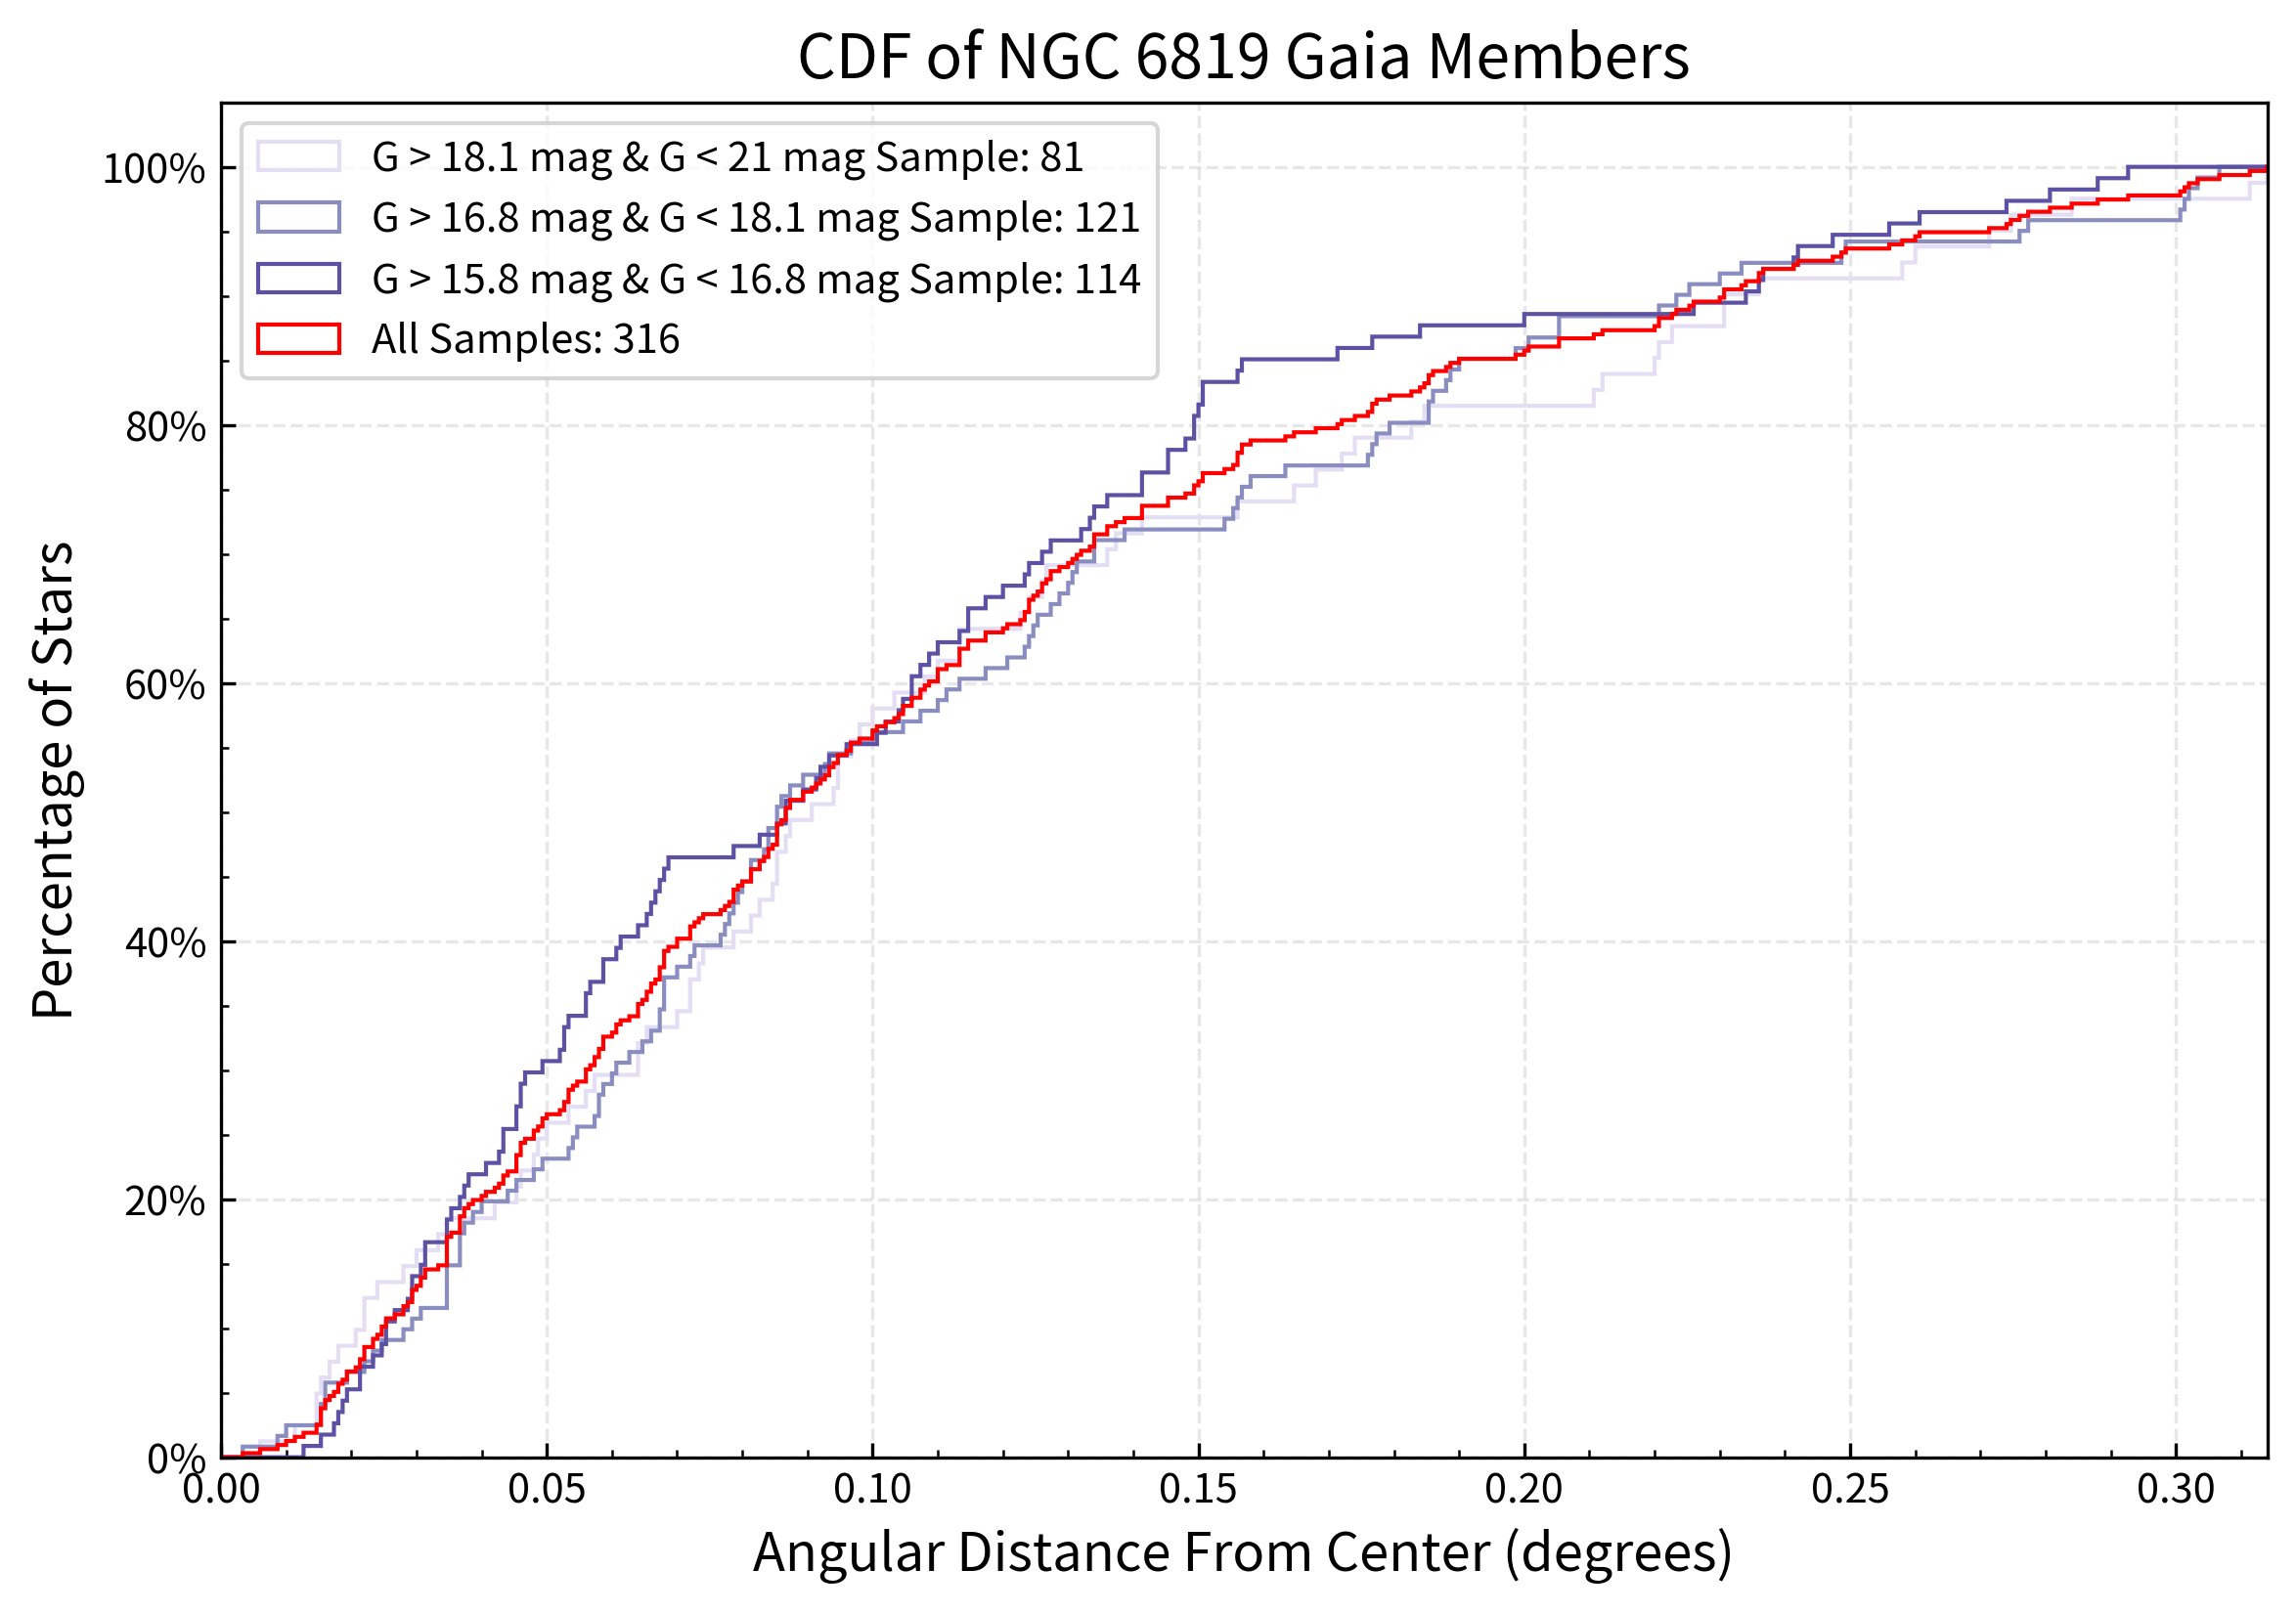

In [ ]:
#G magnitude ranges CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

#filters from lowest mag to highest mag
binaryfilter1 = binaryGaiaData.loc[(binaryGaiaData['G']  >= 18.1) & (binaryGaiaData['G']  <= 21)]
binaryfilter2 = binaryGaiaData.loc[(binaryGaiaData['G']  > 16.8) & (binaryGaiaData['G']  <=  18.1)]
binaryfilter3 = binaryGaiaData.loc[(binaryGaiaData['G']  > 15.8 ) & (binaryGaiaData['G']  <=  16.8)]
binaryfilterAll = binaryGaiaData.loc[(binaryGaiaData['G']  <= 21) & (binaryGaiaData['G']  > 15.8 )]
#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

bin1 = binaryfilter1['distance']
bin2 = binaryfilter2['distance']
bin3 = binaryfilter3['distance']
allbinaries = binaryfilterAll['distance']
#print(binaryfilter1)

bin1Sample = bin1.shape[0]
bin2Sample = bin2.shape[0]
bin3Sample = bin3.shape[0]
allSample = bin1Sample + bin2Sample + bin3Sample
# print(binary)

ax.hist(bin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#e4def5', label=f'G > 18.1 mag & G < 21 mag Sample: {bin1Sample}')
ax.hist(bin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#8A8DC0', label=f'G > 16.8 mag & G < 18.1 mag Sample: {bin2Sample}')
ax.hist(bin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#5D51A3', label=f'G > 15.8 mag & G < 16.8 mag Sample: {bin3Sample}')
ax.hist(allbinaries, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='r', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(bin1,bin2)
ks_result, less_pvalue1 = ks_2samp(bin1,bin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(bin2,bin3)
ks_result, less_pvalue2= ks_2samp(bin2,bin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(bin1,bin3)
ks_result, less_pvalue3 = ks_2samp(bin1,bin3,alternative='less')
print(twoside_pvalue3 )

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.legend(loc='upper left')
# plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\n1.0M$\odot$ - 1.3M$\odot$ Sample: {binarySample}\n0.6M$\odot$ - 1.0M$\odot$ Sample: {singleSample}',fontsize = 10, 
#          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
# plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
# plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

0.004447343448980906


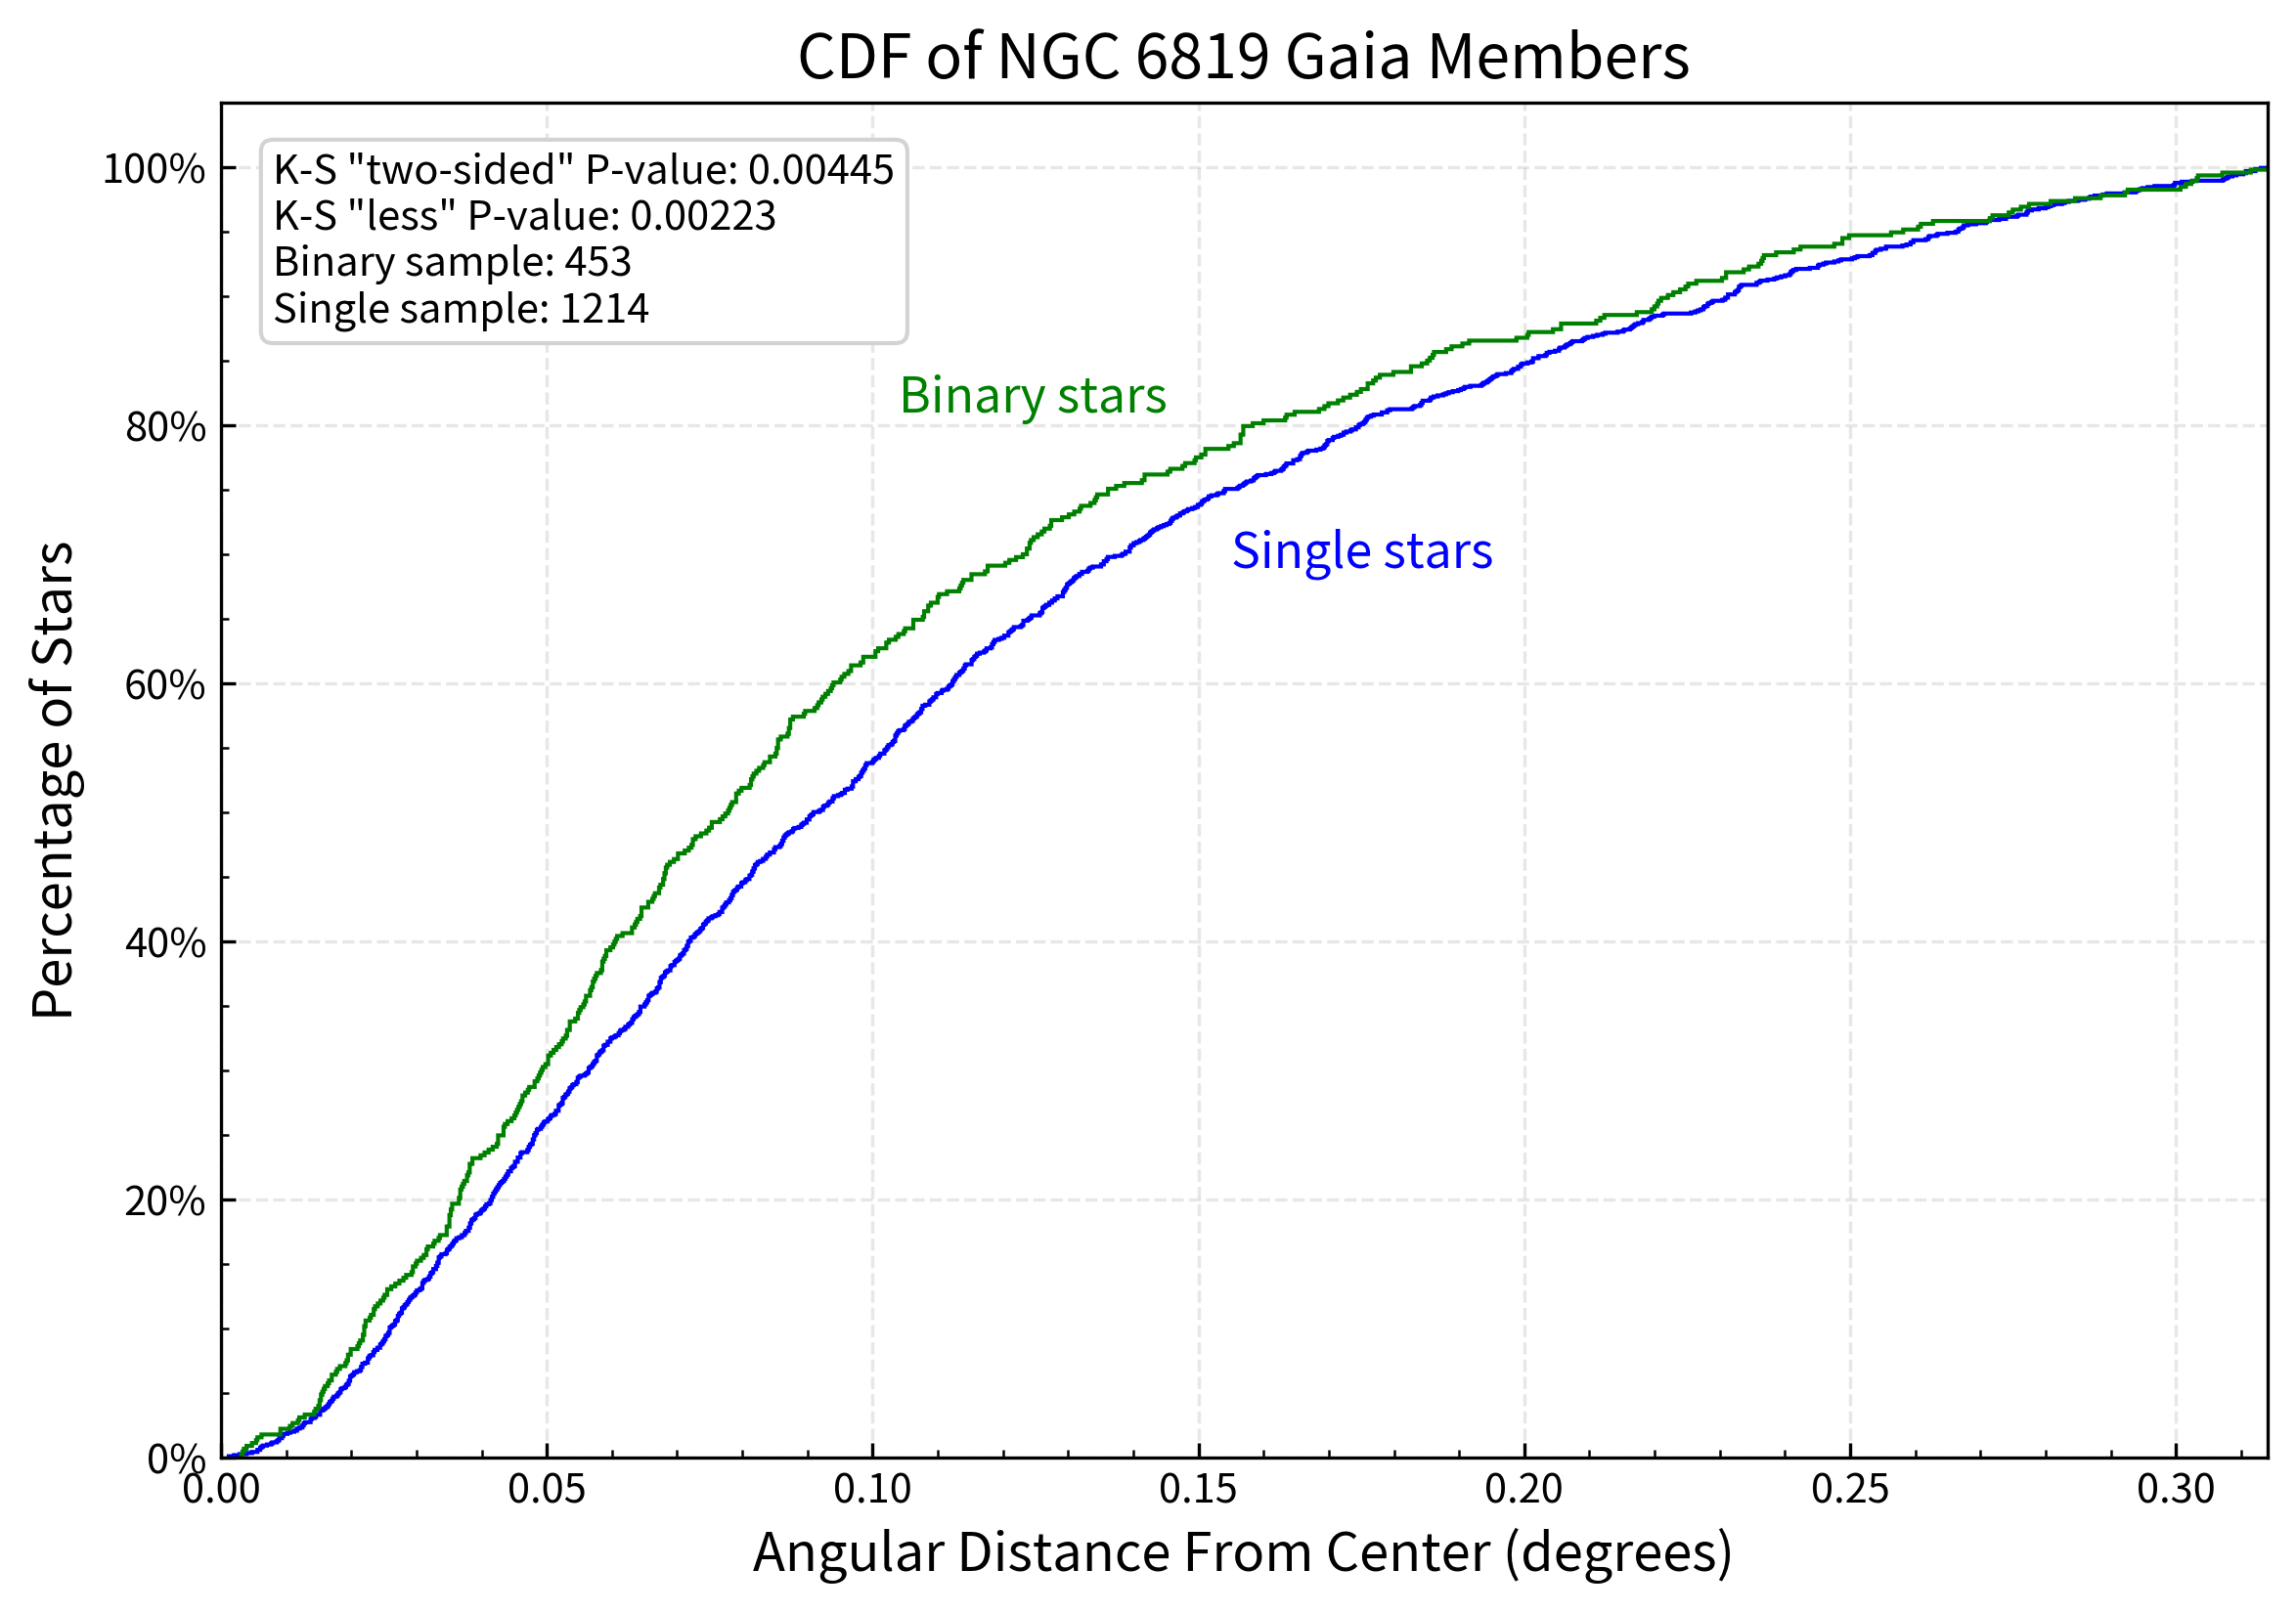

In [ ]:
#full sample CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = singleGaiaData['distance']
binary = binaryGaiaData['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b')
ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print(twoside_pvalue)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

0.0837712718470728


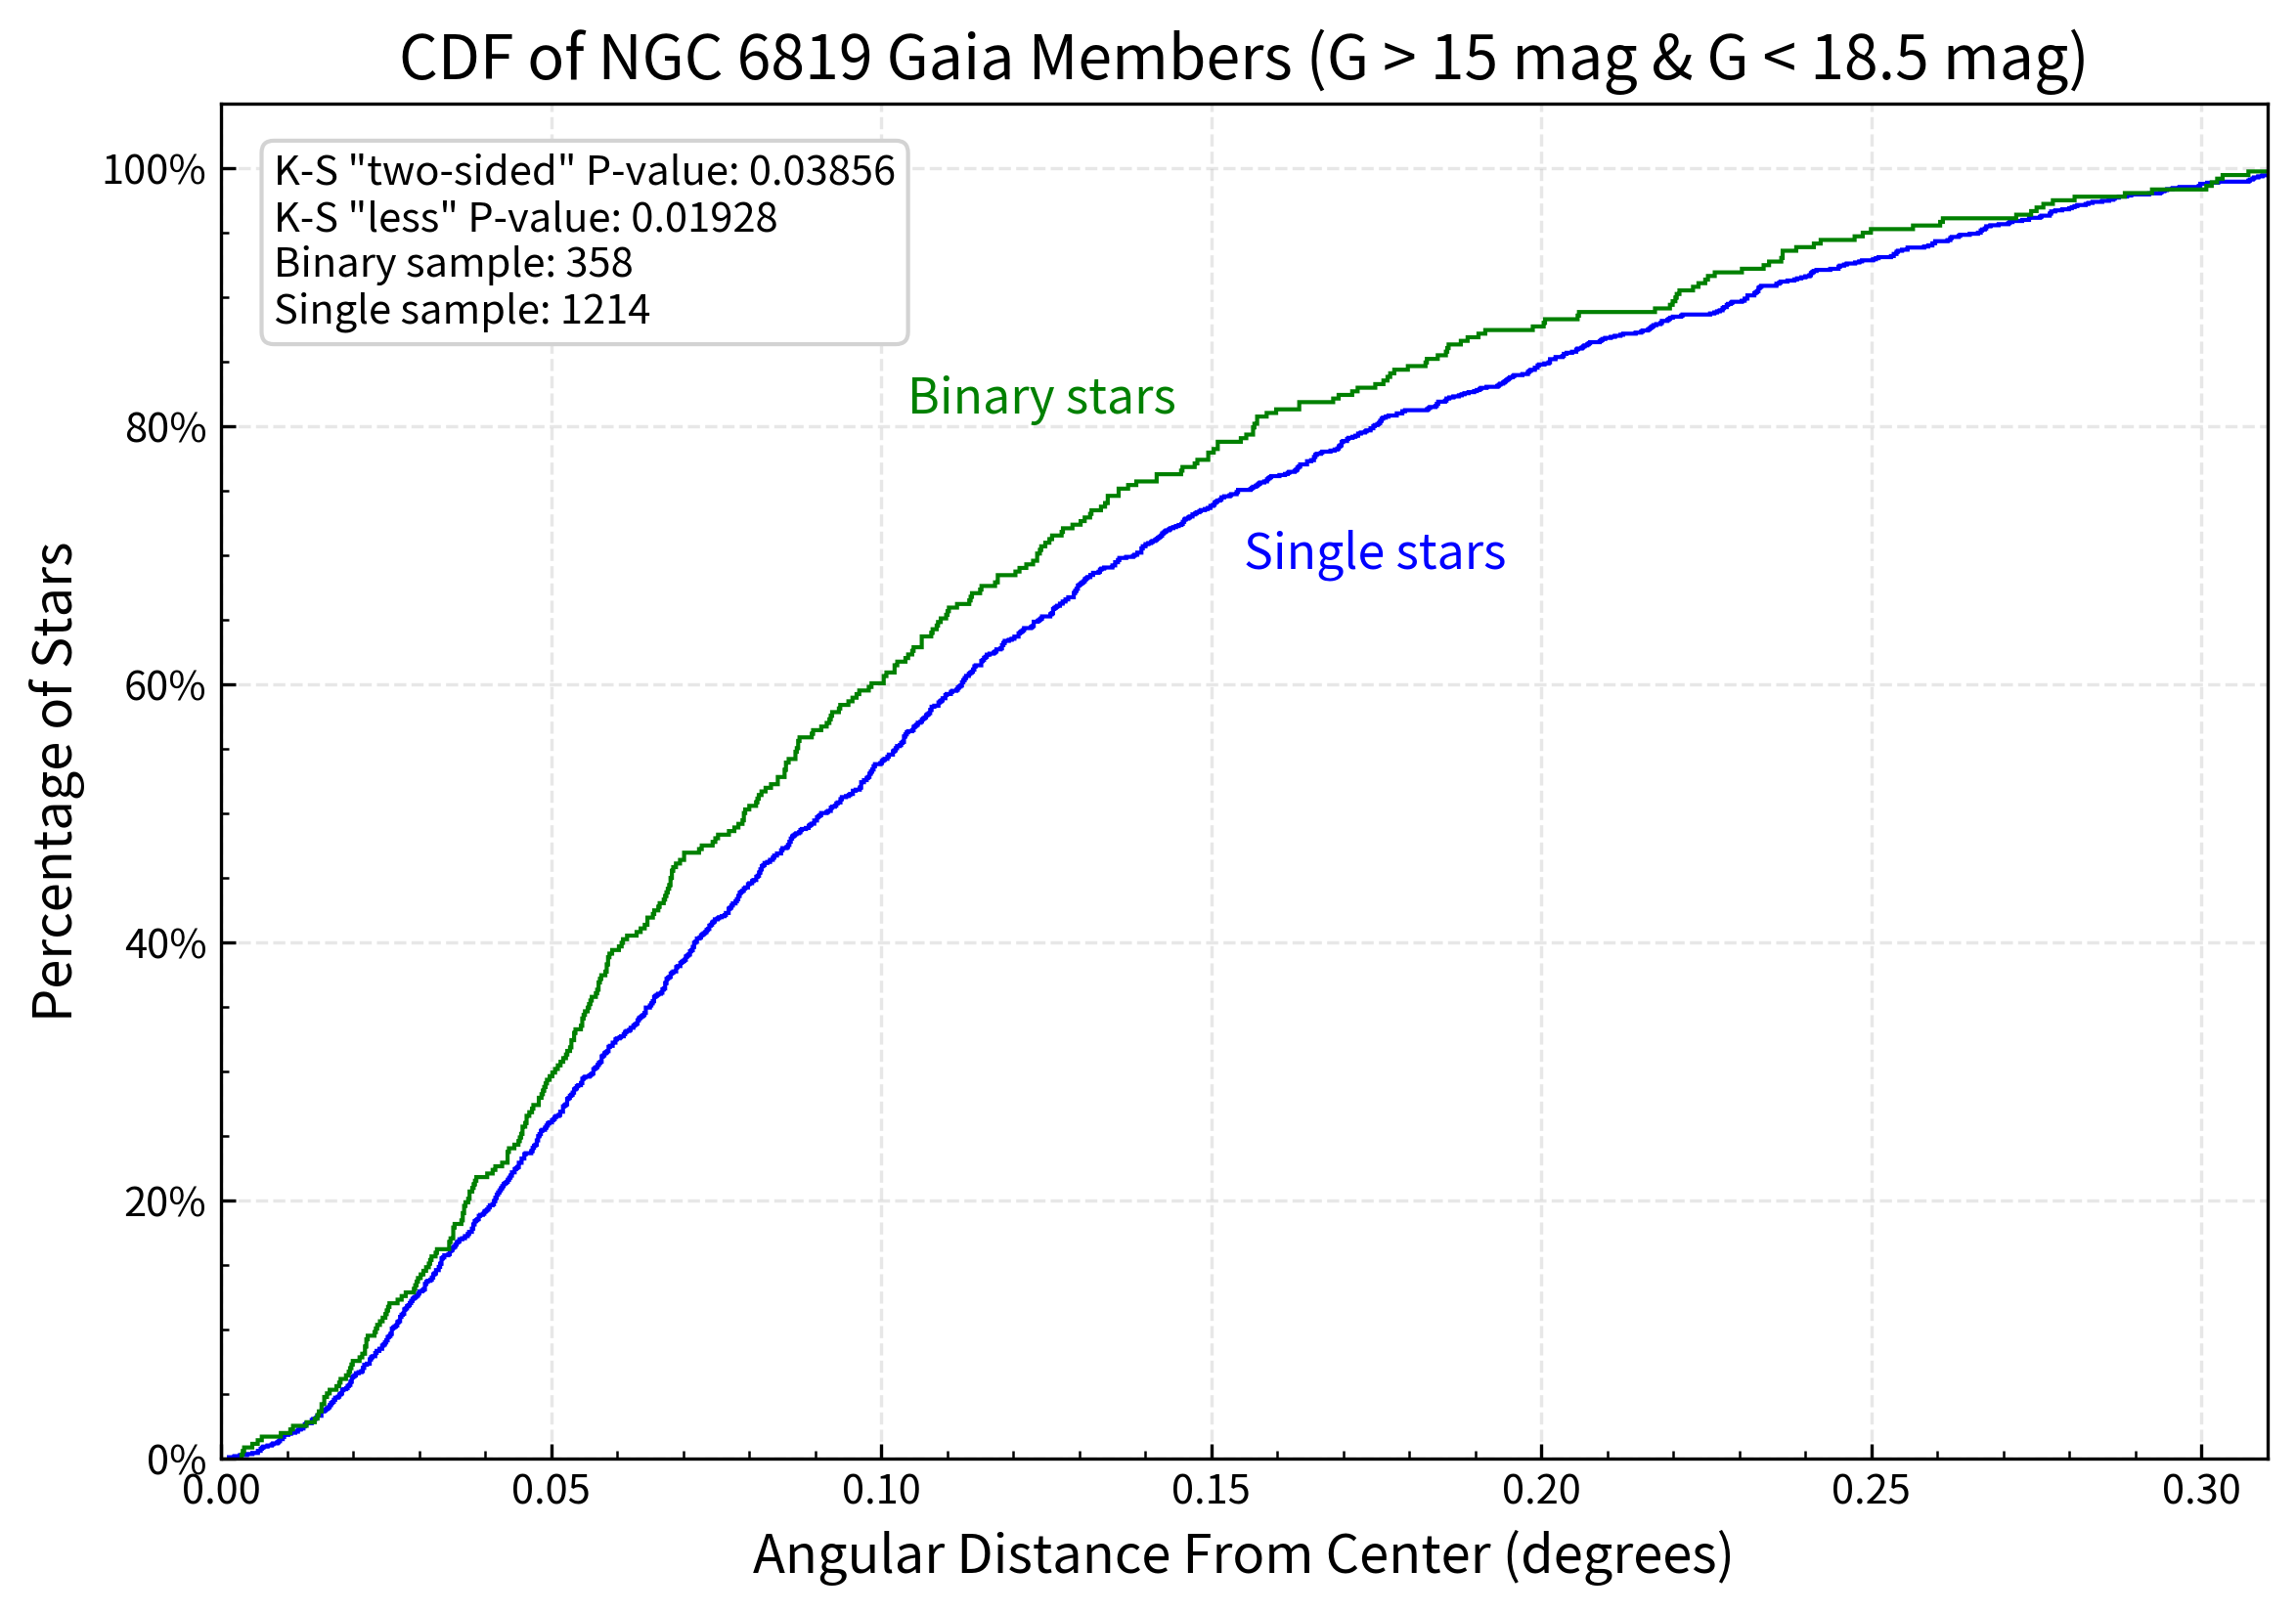

In [ ]:
#topmag and bottommag CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = singleGaiaData['distance']
binary = cutBinaryGaiaData['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b')
ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print(ks_result)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members (G > 15 mag & G < 18.5 mag)", fontsize=15)
plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-')]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.31)
plt.show()

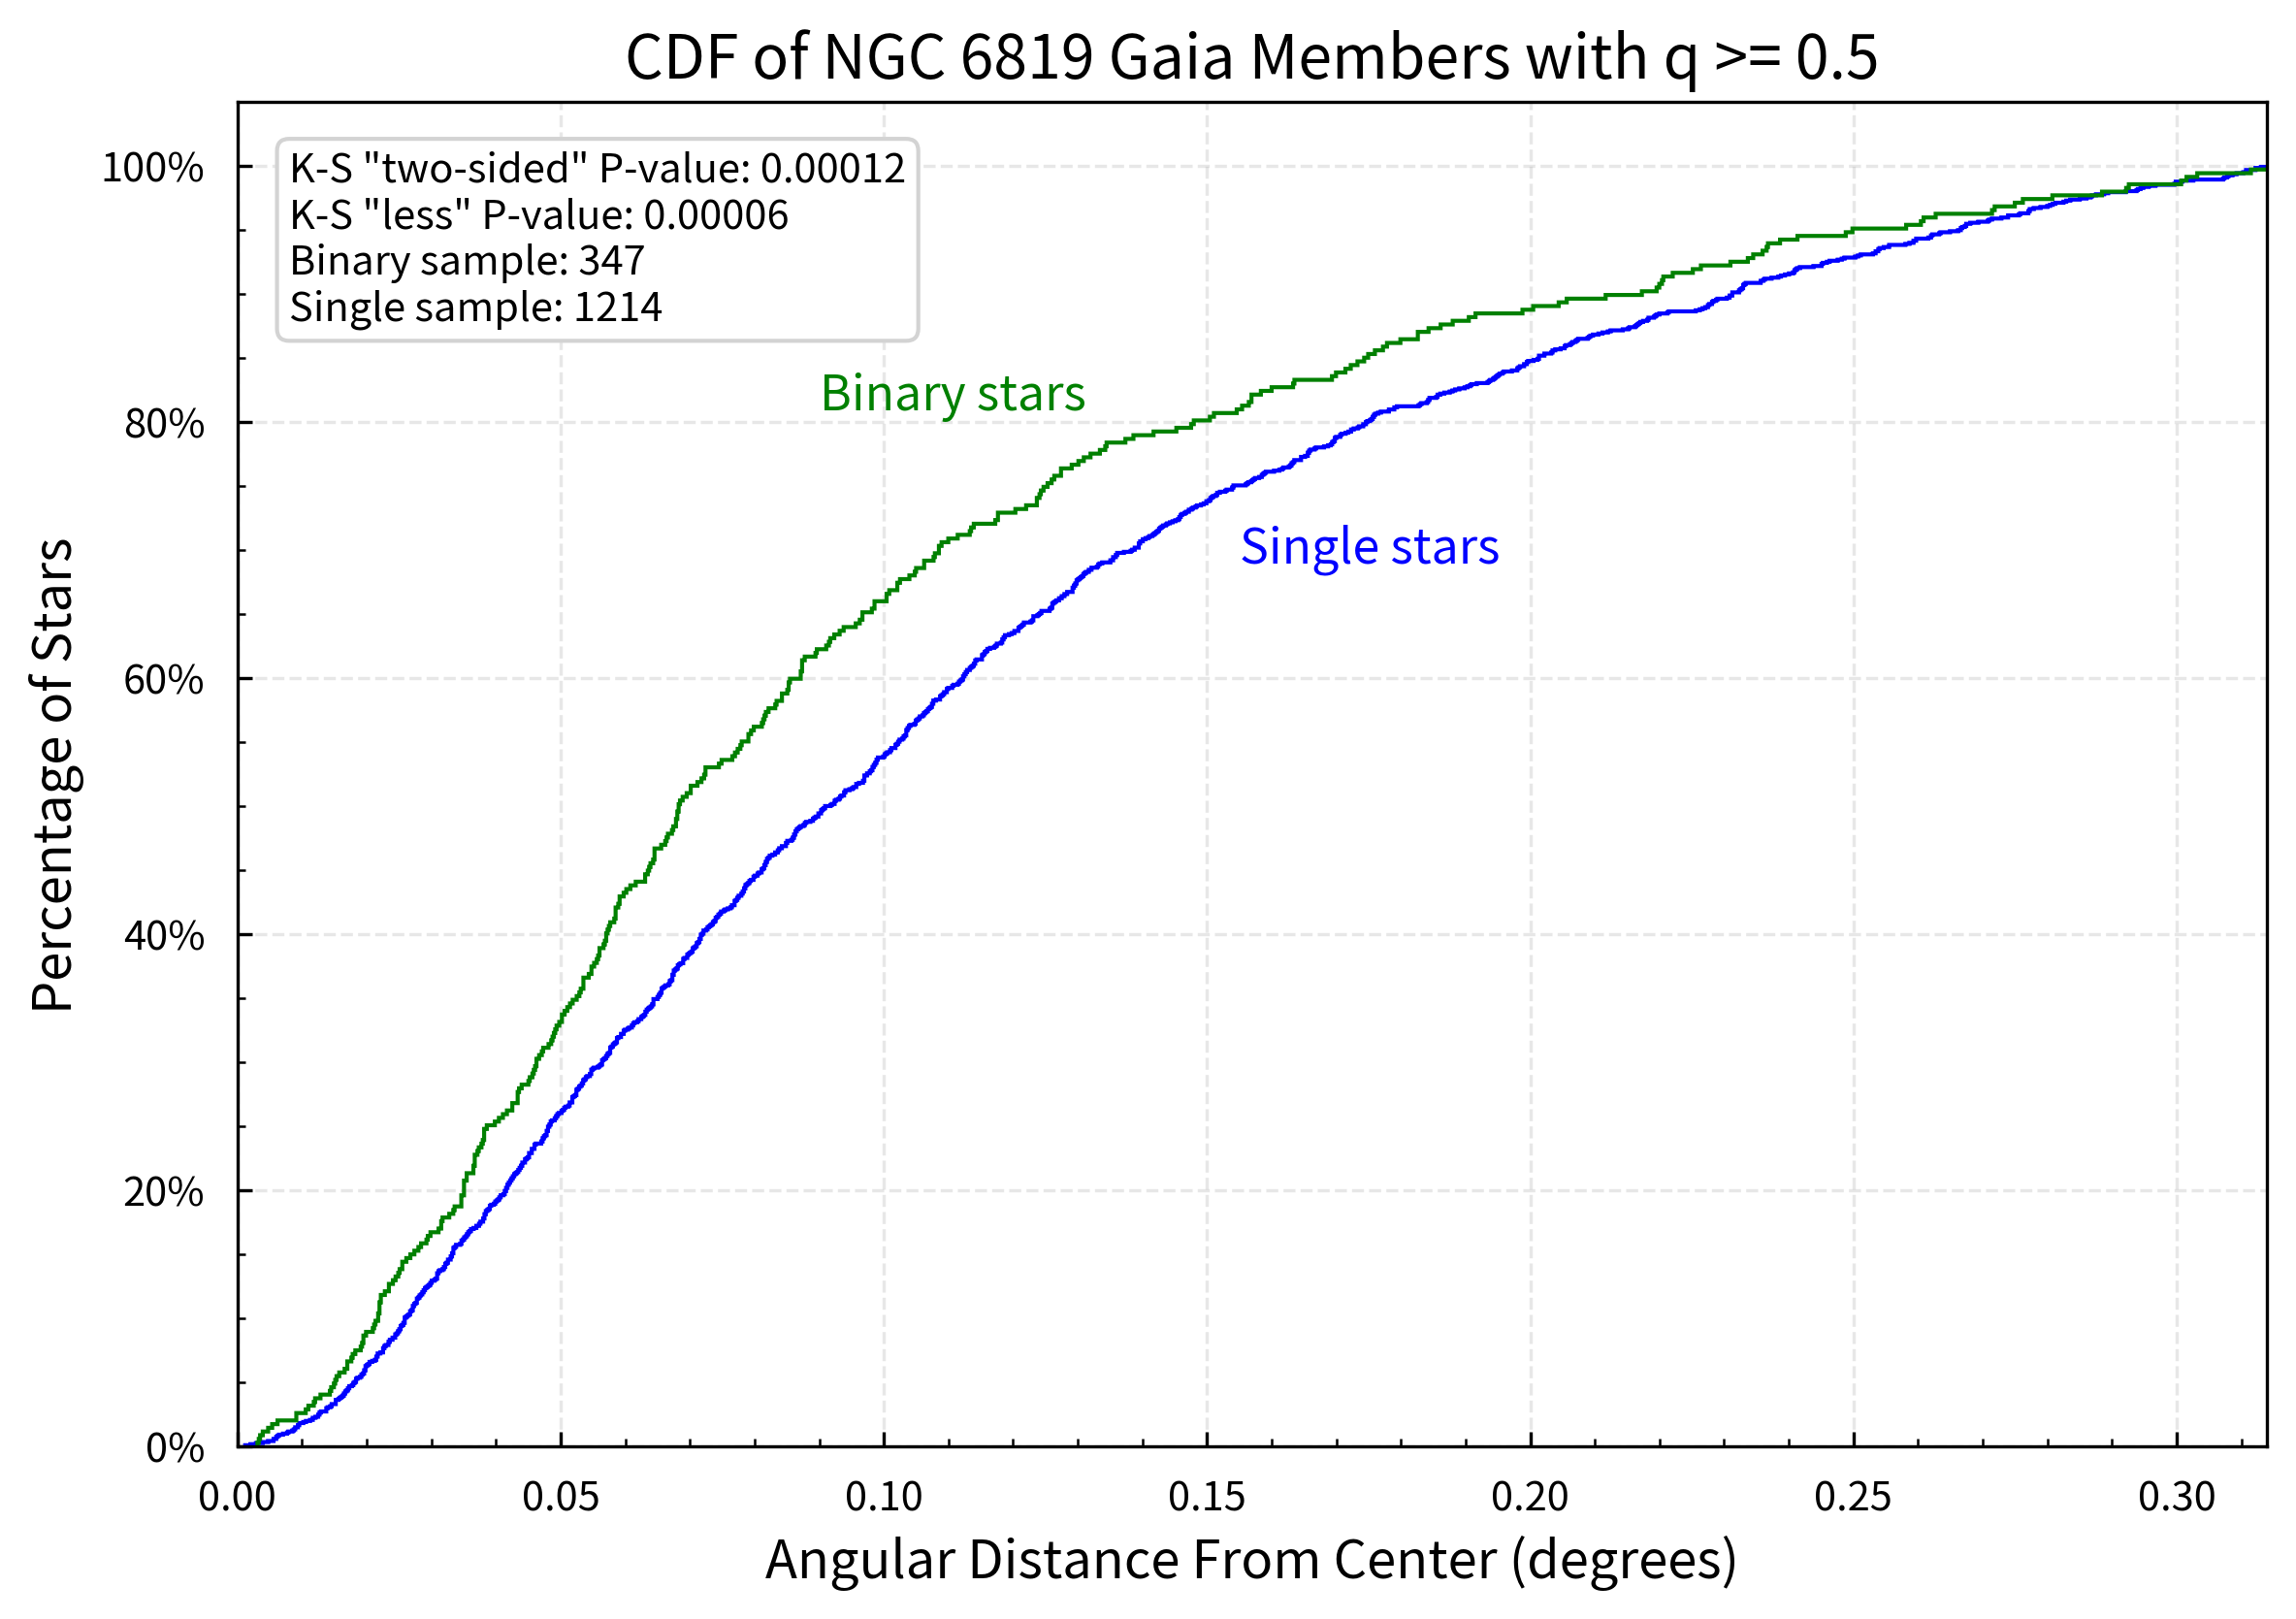

In [ ]:
#massratio CDF
# Select rows where qMean is greater than or equal to 0.5
qcutSingle = singleGaiaData[singleGaiaData['qMean'] >= 0.00000000001]
qcutBinary = binaryGaiaData[binaryGaiaData['qMean'] >= 0.5]

f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = qcutSingle['distance']
binary = qcutBinary['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b', label=f'Single stars (n={singleSample}) ')
binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g', label= f'Binary stars (n={binarySample}) ')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)

plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),]

# twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
# less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
#ax.legend(loc=2, fontsize=8)
#leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

plt.annotate(text="Binary stars", color='g', xy=(.09,.81), xytext=(.09,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.314)
plt.show()

In [ ]:
# Nbins= np.linspace(1, 1.4, 6)
# print(Nbins)

In [ ]:
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# counts1, bins1, bars1 = plt.hist(binaryGaiaData['m1Mean'],Nbins, linewidth=2,color='purple',rwidth=0.97)
# plt.ylabel('N',fontsize=13)
# plt.xlabel('Primary masses (m1)',fontsize=13)
# plt.title('PDF of NGC 6819 Binary Star Primary Masses', fontsize=15)
# plt.show()
# print(counts1, bins1)

In [ ]:
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# counts2, bins2, bars2 = plt.hist(singleGaiaData['m1Mean'],Nbins, linewidth=2,color='purple',rwidth=0.97)
# plt.ylabel('N',fontsize=13)
# plt.xlabel('Primary mass(M1)',fontsize=13)
# plt.title('PDF of NGC 6819 Single Star Primary Masses', fontsize=15)
# plt.show()

In [ ]:
# errors_y3 = np.sqrt(counts1)/counts2
# print(errors_y3)

In [ ]:
# print(bins1)
# #find halfway point between first and second bin
# print(bins1 + (bins1[1]-bins1[0])/2 )
# print(bins1[1]-bins1[0],bins1[2]-bins1[1])

# print(len(bins1), len(counts1/counts2))

In [ ]:
# print(bins1[:-1] + (bins1[1]-bins1[0])/2)

In [ ]:
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# print(bins1,bins2)
# primarybins = bins1[:-1] + (bins1[1]-bins1[0])/2

# plt.errorbar(primarybins, counts1/(counts1 +counts2), xerr=None, yerr=errors_y3, fmt='o',capsize=5, color='black', ecolor='red')
# plt.ylabel('Binary fraction',fontsize=13)
# plt.xlabel('Primary mass',fontsize=13)
# plt.title('NGC 6819 Binary Fraction as a function of Primary Mass', fontsize=15)
# plt.show()

In [ ]:
# counts2

In [ ]:
# twod_histbins = np.linspace(0.5,1,6)
# print(twod_histbins)

In [ ]:
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# plt.hist2d(binaryGaiaData['qMean'], binaryGaiaData['m1Mean'], bins=[twod_histbins,5], cmap='Purples', vmax=30)
# cb = plt.colorbar(label='counts per bin', extend='max')
# plt.xlabel('Mass Ratio',fontsize=13)
# plt.ylabel('Primary Mass',fontsize=13)
# plt.title("Primary Mass and Mass Ratio distribution", fontsize=15)
# plt.show()

In [ ]:
# #qmean and distance
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# plt.hist2d(binaryGaiaData['qMean'], binaryGaiaData['distance'], bins=[twod_histbins, 5], cmap='Purples', vmax=25)
# cb = plt.colorbar(label='counts in bin', extend='max')
# plt.xlabel('Mass Ratio',fontsize=13)
# plt.ylabel('Distance from cluster center',fontsize=13)
# plt.title("Distance from cluster center and Mass Ratio distribution", fontsize=15)
# plt.show()

In [ ]:
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# counts, bins, bars =plt.hist(binaryGaiaData['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
# plt.xlabel('Distance from Cluster Center',fontsize=13)
# plt.ylabel('N',fontsize=13)
# plt.title("PDF of NGC 6819 Binary Star Cluster Center Distance", fontsize=15)
# plt.show()

In [ ]:
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# counts2, bins2, bars2 = plt.hist(singleGaiaData['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
# plt.xlabel('Distance from Cluster Center',fontsize=13)
# plt.ylabel('N',fontsize=13)
# plt.title('PDF of NGC 6819 Single Star Cluster Center Distance')
# plt.show()

In [ ]:
# bins

In [ ]:
# # is this the right way to do error? can we factor in the std of the values themselves?
# errors_y = np.sqrt(counts)/counts2


In [ ]:
# bins3 = [ 0.20038481, 0.39769111, 0.5949974 , 0.79230369,
#        0.98960999 ]

# plt.xlabel('distance from cluster center',fontsize=15)
# plt.ylabel('binary fraction',fontsize=15)
# plt.scatter(bins3, counts/counts2, color='blue')

In [ ]:
# plt.xlabel('distance from cluster center',fontsize=15)
# plt.ylabel('binary fraction',fontsize=15)
# plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')

## plots of Only the center of CMD  13-17

In [ ]:
# counts5, bins5, bars5 = plt.hist(cutBinaryGaiaData['m1Mean'],bins=np.linspace(1,1.4, 8), linewidth=2,color='purple',rwidth=0.97)
# plt.ylabel('N(binaries) cut',fontsize=15)
# plt.xlabel('Primary mass(M1) cut',fontsize=15)

In [ ]:
# bins5

In [ ]:
# counts6, bins6, bars6 = plt.hist(cutSingleGaiaData['m1Mean'],bins=np.linspace(1,1.4, 8),linewidth=2,color='purple',rwidth=0.97)
# plt.ylabel('N cut',fontsize=15)
# plt.xlabel('Primary mass(M1) cut',fontsize=15)

In [ ]:
# bins6

In [ ]:
# # the arrays arent the same size. should i be getting rid of the first bin value or last?
# primarybins2 = bins5[:-1] + (bins5[1]-bins5[0])/2
# errors_y4 = np.sqrt(counts5)/counts6
# plt.errorbar(primarybins2, counts5/counts6, xerr=None, yerr=errors_y4, fmt='o',capsize=5, color='black', ecolor='red')
# plt.ylabel('binary fraction cut',fontsize=15)
# plt.xlabel('primary mass cut',fontsize=15)

In [ ]:
# plt.hist2d(cutBinaryGaiaData['qMean'], cutBinaryGaiaData['m1Mean'], bins=4, cmap='Blues')
# cb = plt.colorbar(label='counts in bin')
# plt.xlabel('Mass Ratio cut',fontsize=15)
# plt.ylabel('primary mass cut',fontsize=15)

In [ ]:
# #qmean and distance
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
# plt.hist2d(cutBinaryGaiaData['qMean'], cutBinaryGaiaData['distance'], bins=5, cmap='Purples', vmax=25)
# cb2 = plt.colorbar(extend="max",label='counts per bin')
# plt.xlabel('Mass Ratio (cut)',fontsize=13)
# plt.ylabel('Distance from cluster center (cut)',fontsize=13)
# plt.title("Distance from cluster center and Mass Ratio distribution", fontsize=15)
# plt.show()

In [ ]:
# counts7, bins7, bars7 =plt.hist(cutBinaryGaiaData['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
# plt.xlabel('Distance from Cluster Center cut',fontsize=15)
# plt.ylabel('N (binaries) cut',fontsize=15)

In [ ]:
# counts8, bins8, bars8 = plt.hist(cutSingleGaiaData['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
# plt.xlabel('Distance from Cluster Center cut',fontsize=15)
# plt.ylabel('N cut',fontsize=15)

In [ ]:
# bins7 = [0.2,0.4,0.6,0.8,1]
# bins8 = [0,0.2,0.4,0.6,0.8,1]
# bins7 

In [ ]:
# # is this the right way to do error? can we factor in the std of the values themselves?
# errors_y2 = np.sqrt(counts7)/counts8


In [ ]:
# plt.xlabel('distance from cluster center cut',fontsize=15)
# plt.ylabel('binary fraction cut',fontsize=15)
# print(len(bins8), len(errors_y2))
# plt.errorbar(bins8, counts7/counts8, xerr=None, yerr=errors_y2, fmt='o',capsize=5, color='black', ecolor='red')


In [ ]:
# cutBinaryGaiaData.columns

In [ ]:
# f, ax = plt.subplots(figsize=(5,8))
# ax.plot(cutBinaryGaiaData['G_BP'] - cutBinaryGaiaData['G_RP_x'], cutBinaryGaiaData['G'],'.', color='gray')
# ax.set_xlim(0, 3)
# ax.set_ylim(23, 12)

(23.0, 12.0)

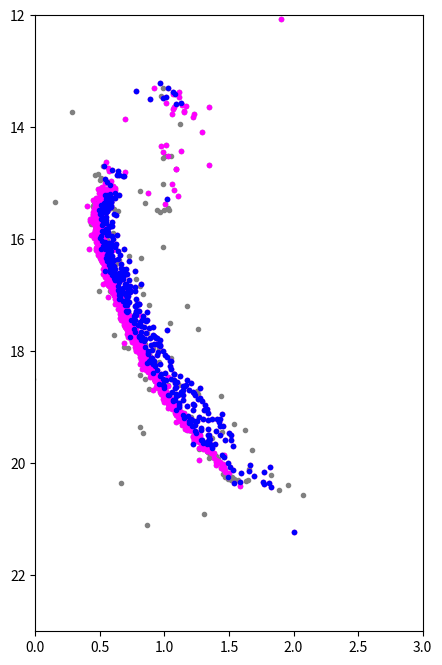

In [ ]:
f, ax = plt.subplots(figsize=(5,8))
photMems = phot.loc[phot['member']]
photBinary = phot.loc[phot['binary']]
ax.plot(phot['g_ps'] - phot['i_ps'], phot['g_ps'],'.', color='gray')
ax.plot(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],'.', color='magenta')
ax.plot(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'],'.', color='blue')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

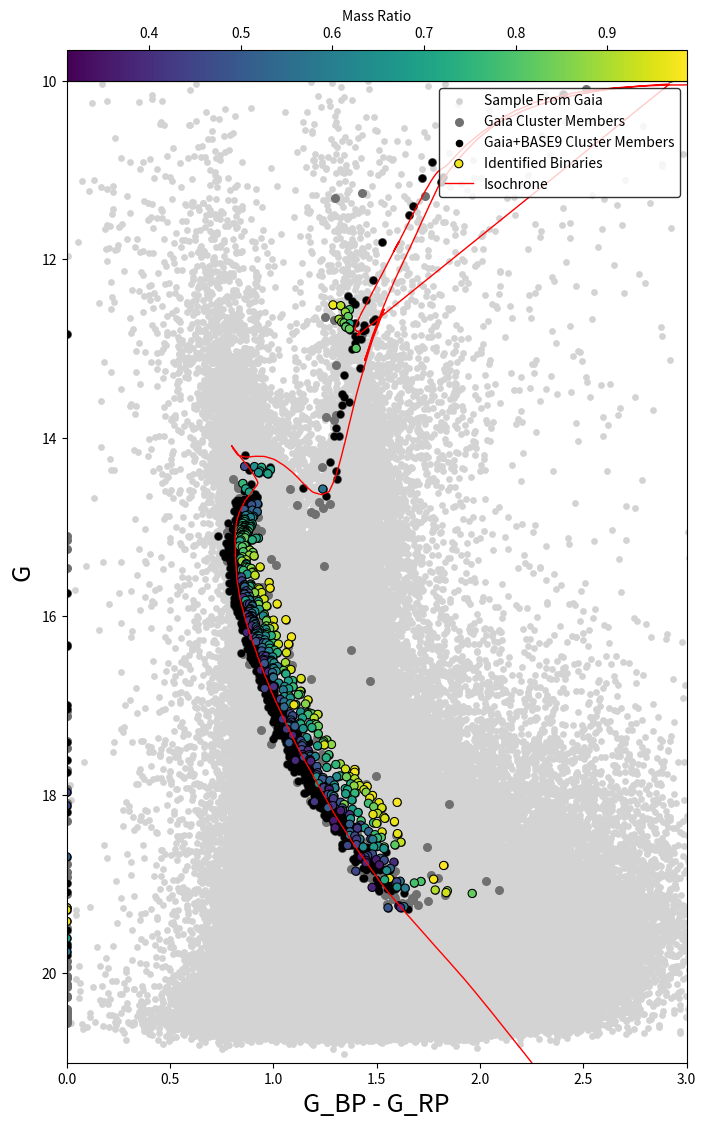

In [ ]:
r = photBinary['qMean']
f, ax = plt.subplots(figsize=(8,15))

ax.set_xlabel('G_BP - G_RP',fontsize=18)
ax.set_ylabel('G',fontsize=18)
#plot phot and cluster members
plt.scatter(originalGaia['G_BP'] - originalGaia['G_RP'], originalGaia['G'],s=15, color='lightgray',label='Sample From Gaia')
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='#707070',label='Gaia Cluster Members')
plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=20, color='#000000',label='Gaia+BASE9 Cluster Members')
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')
ax.set_xlim(0, 3)
ax.set_ylim(21,10)


#plot colorbar
plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75,label='Identified Binaries')

plt.colorbar(label="Mass Ratio", orientation="horizontal",pad=0,location='top')


#overplot isochrone
photfile = ph
cmdfile = r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag       = 'G'
color     = 'G_BP-G_RP'.split('-')
header   = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red',linewidth=1,label='Isochrone')
plt.legend(loc="upper right",edgecolor='black')
#plt.show()
plt.savefig('MegaCMD1.png',dpi=300, bbox_inches="tight")
    


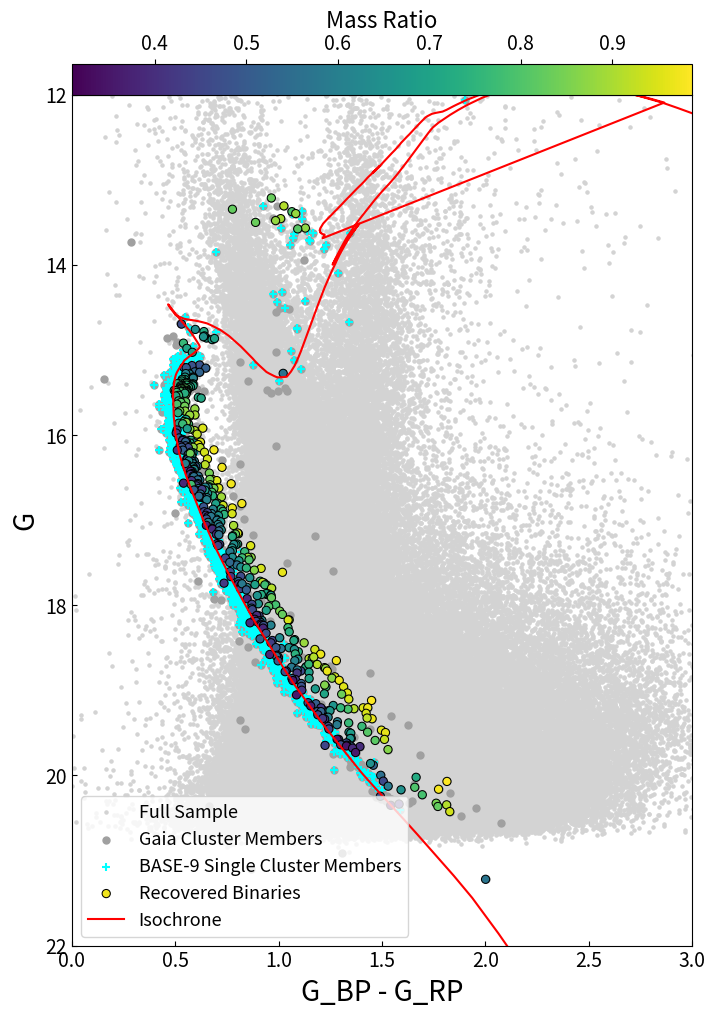

In [ ]:
r = photBinary['qMean']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['g_ps'] - phot['i_ps'], phot['g_ps'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("Mass Ratio", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag     = "g_ps"
color     = "g_ps-i_ps".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithMassRatio.png', dpi=300)

plt.show()

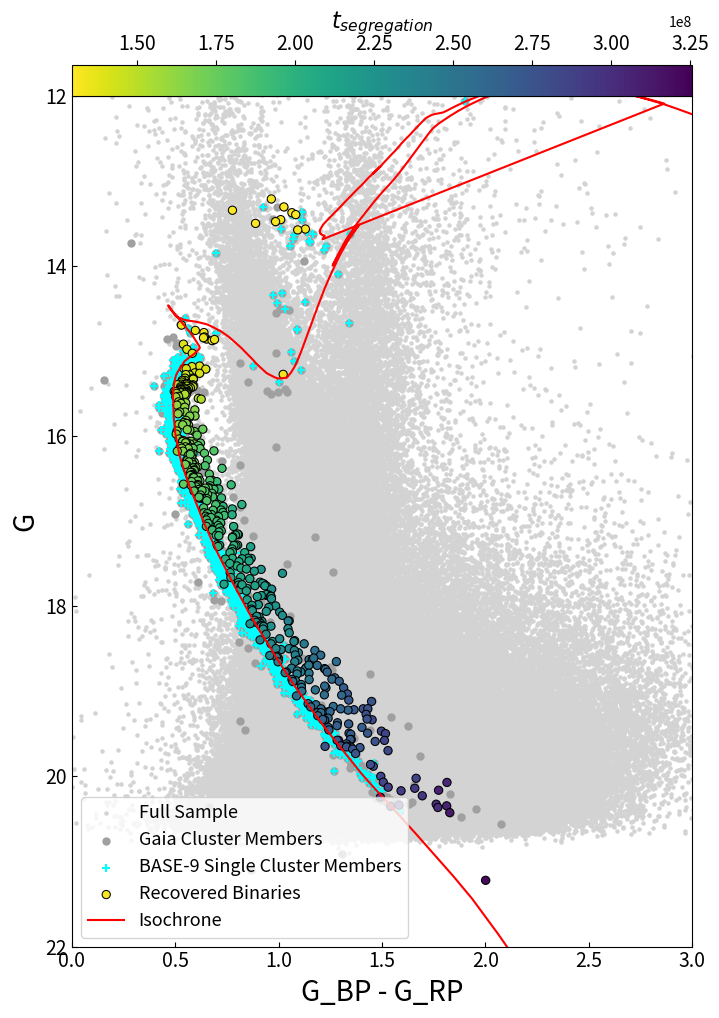

In [ ]:
r = photBinary['t_seg']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['g_ps'] - phot['i_ps'], phot['g_ps'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], s=35, c=r, cmap=plt.cm.get_cmap("viridis").reversed(),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("$t_{segregation}$", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag     = "g_ps"
color     = "g_ps-i_ps".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithtSegregation.png', dpi=300)

plt.show()

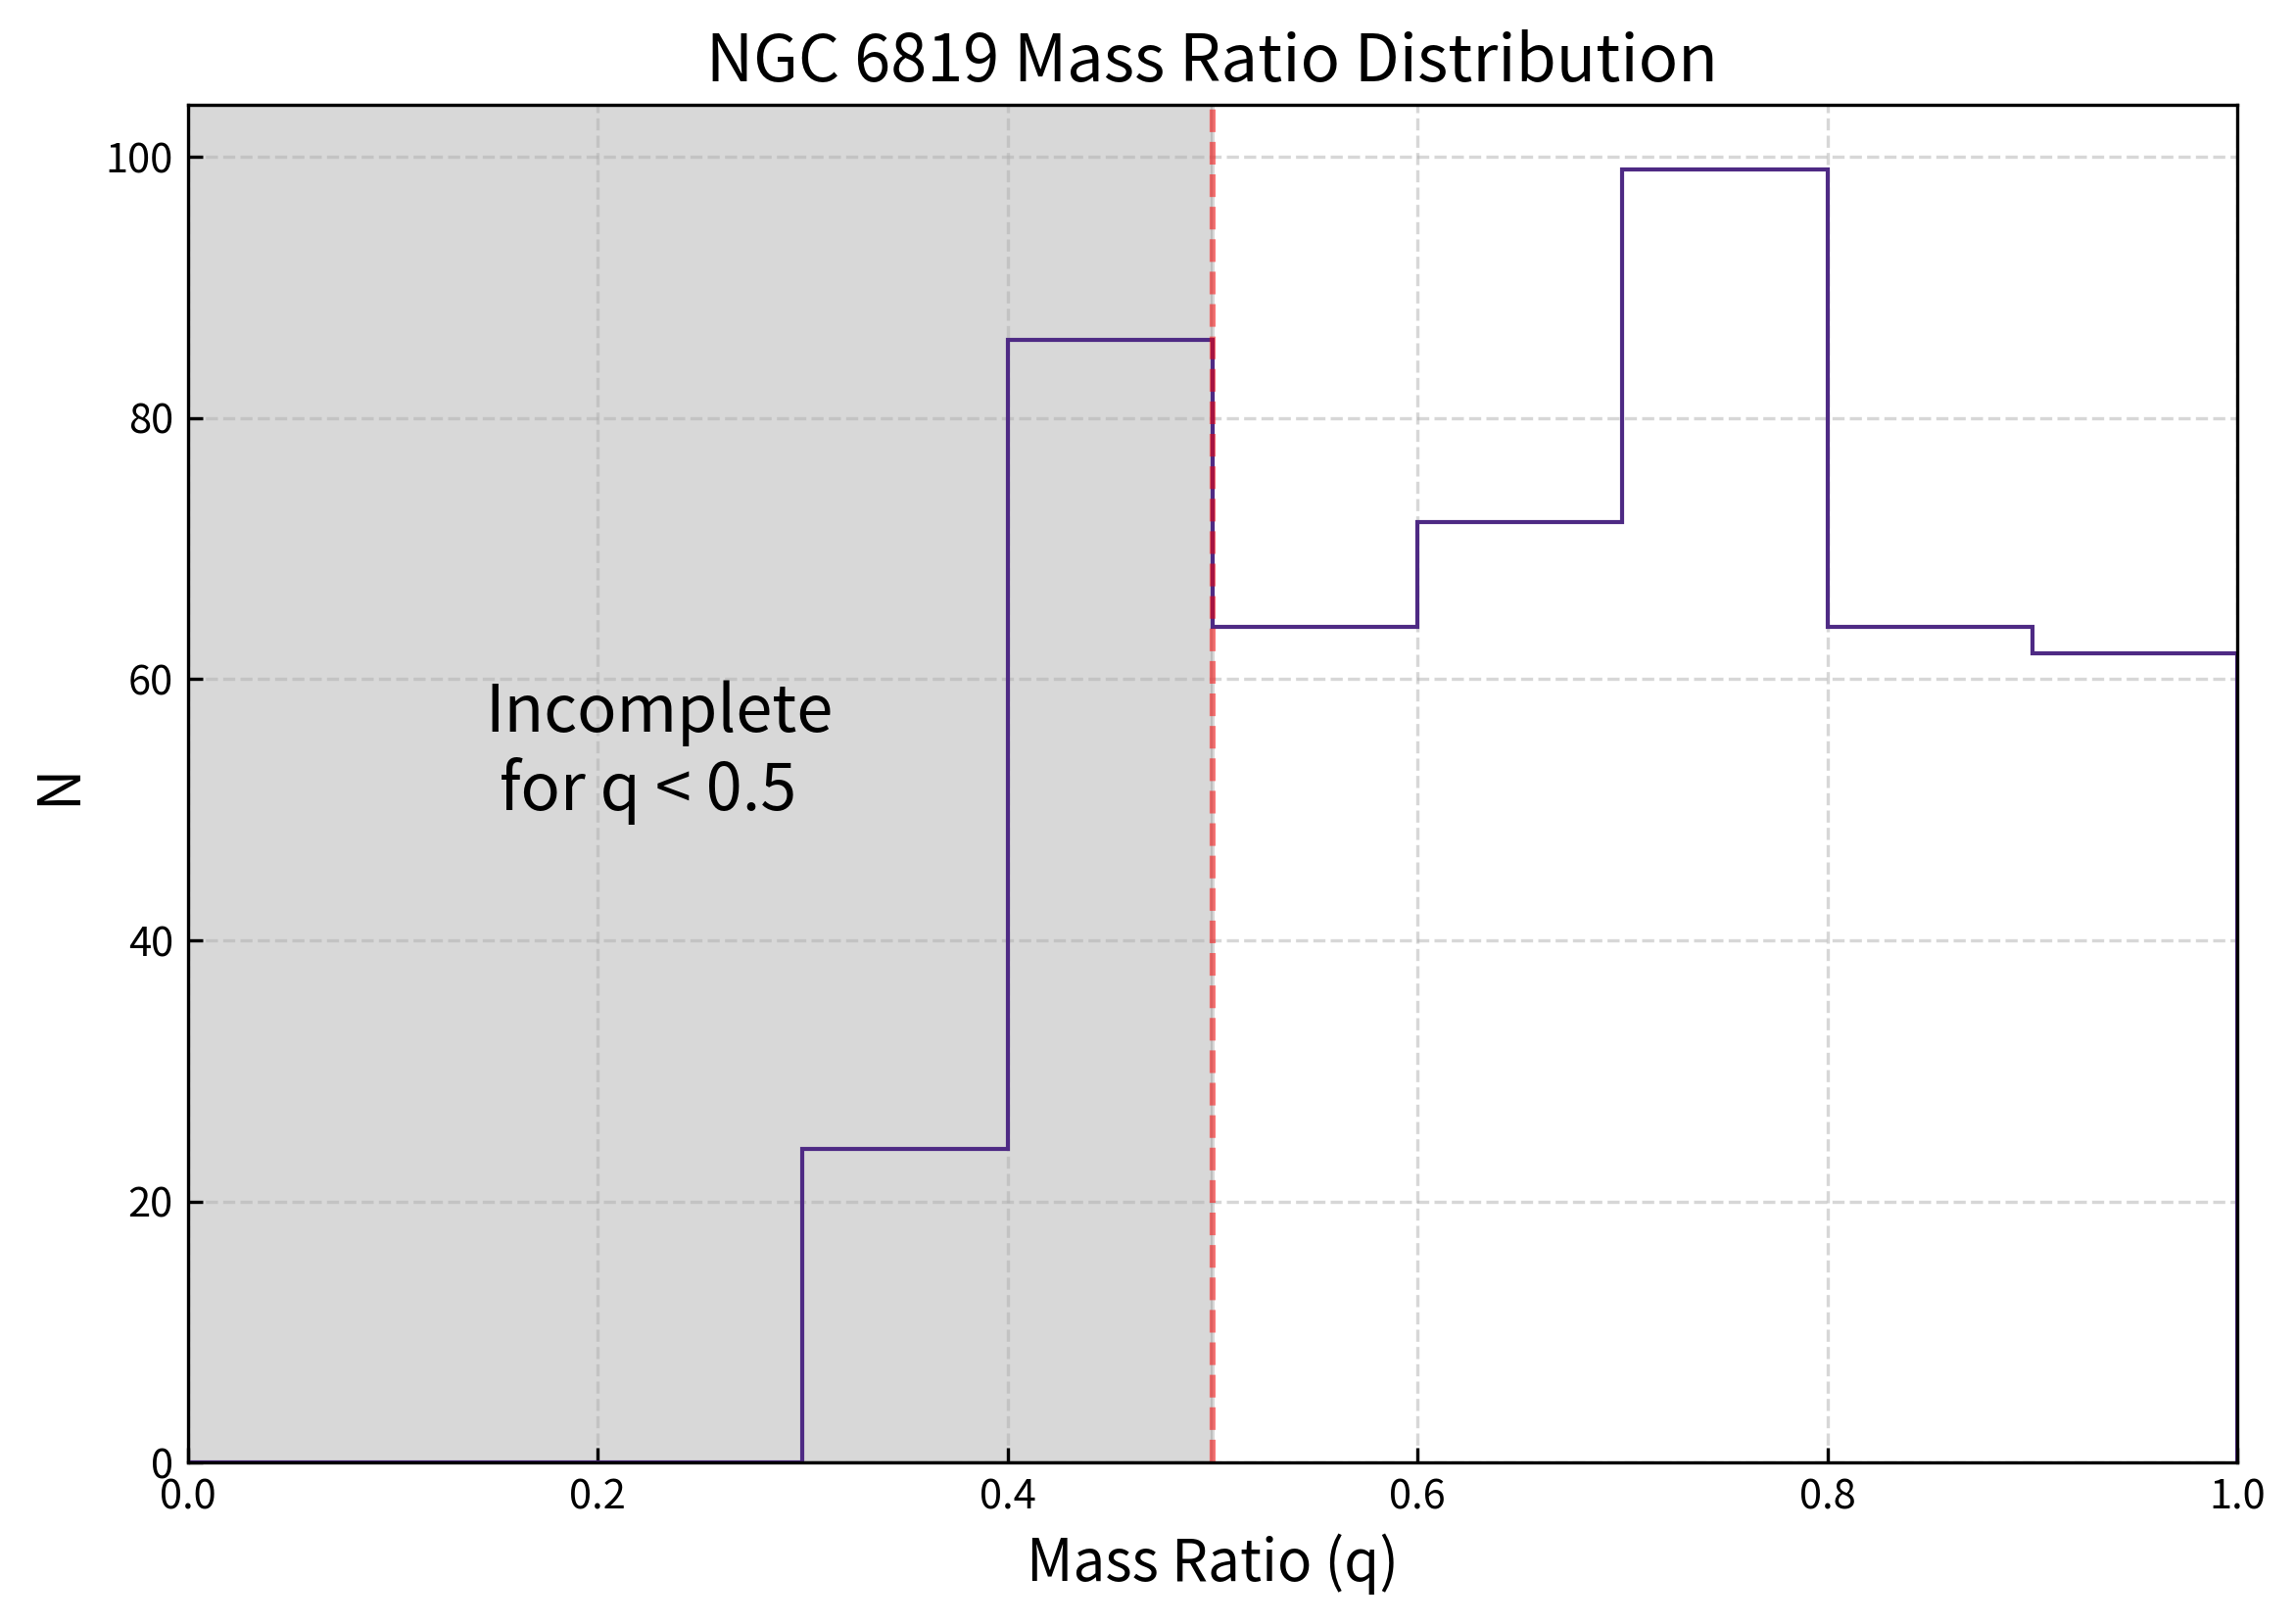

In [ ]:
f, ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
photBinary = phot.loc[phot['binary']]
_ = ax.hist(photBinary['qMean'], histtype='step', color="#4e2a84" ,bins=10, range=[0,1])
ax.set_xlabel("Mass Ratio (q)", fontsize=14)
ax.set_ylabel("N", fontsize=14)
ax.annotate(text='Incomplete\n for q < 0.5', xy=(.145,50), xytext=(.145,50), fontsize=16)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.axvspan(0,0.5, color='gray', alpha=0.3)
ax.set_title("NGC 6819 Mass Ratio Distribution", fontsize=16)
plt.grid(linestyle='--', alpha=0.5)
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,1)
plt.savefig("massratio.png", dpi=300)

In [ ]:
# f, ax = plt.subplots()
# photBinary = phot.loc[phot['binary']]
# _ = ax.hist(photBinary['qMean'], bins=10, range=[0,1],linewidth=2,color='#900C3F',rwidth=0.97)
# ax.set_xlabel('Mass Ratio (q)',fontsize=15)
# ax.set_ylabel('N',fontsize=15)
# #plt.savefig('M67qhist1.png',dpi=300, bbox_inches="tight")

In [ ]:
# f, ax = plt.subplots(figsize=(6,10))

# ax.set_xlabel('G_BP - G_RP',fontsize=20)
# ax.set_ylabel('G',fontsize=20)
# #plot phot and cluster members
# plt.scatter(M67.data['phot_bp_mean_mag'] - M67.data['phot_rp_mean_mag'], M67.data['phot_g_mean_mag'],s=15, color='lightgray',label='Sample From Gaia')
# plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='Deeppink',label='Gaia Cluster Members', edgecolors= "black",linewidth=0.2)
# ax.set_xlim(0, 3)
# ax.set_ylim(21,10)
# #plt.savefig('M67cmd.png', bbox='tight',dpi=300)